# Clustering Experiment & XGBoost

Goal: Group article ids with similar sales trends 

## TODOS

- [ ] Delete code chunks that aren't needed, especially clustering that isn't useful

- [ ] Set default plotting colors?

- [ ] Investigate these articles:
    - [ ] 34**s & 85876 - missing sales data from July-Aug 2017 (Mass Market, Passenger, Touring tires)

## Set up notebook

In [183]:
# general python and plotting packages
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.plotting import scatter_matrix
import glob
import bridgestone as b
import json

import warnings

In [12]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor

/Users/jordannieusma/miniconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
%pip install flaml

  Using cached FLAML-1.2.0-py3-none-any.whl (250 kB)
  Using cached lightgbm-3.3.5.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [86 lines of output]
      INFO:root:running bdist_wheel
      /Users/jordannieusma/miniconda3/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      INFO:root:running build
      INFO:root:running build_py
      INFO:root:creating build
      INFO:root:creating build/lib
      INFO:root:creating build/lib/lightgbm
      INFO:root:copying lightgbm/callback.py -> build/lib/lightgbm
      INFO:root:copying lightgbm/compat.py -> build/lib/lightgbm
      INFO:root:copying lightgbm/plotting.py -> build/lib/lightgbm
      INFO:root:copying lightgbm/__init__.py -> build/lib/lightgbm
     

In [4]:
from flaml import AutoML
#from shapely.geometry import Point
from flaml import AutoML
from flaml.automl.data import load_openml_dataset, get_output_from_log
from flaml.automl.ml import sklearn_metric_loss_score
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'flaml'

In [3]:
# Navigate to data directory
%cd /Users/jordannieusma/Documents/Documents-Laptop/Github

/Users/jordannieusma/Documents/Documents-Laptop/GitHub


In [5]:
# Read-in data
sales = pd.read_csv("final_sales.csv", parse_dates=["DATE"], 
                    usecols=["ARTICLE_ID","DATE","UNITS"], 
                    dtype={"ARTICLE_ID":"category","UNITS":np.float64},
                    low_memory=False)

# Sort
sales.sort_values(by=["DATE","ARTICLE_ID"], inplace=True)

# Group the rows by ARTICLE_ID and month of DATE, and sum the UNITS values
temp = sales.groupby(['ARTICLE_ID', pd.Grouper(key='DATE', freq='M')])['UNITS'].sum().reset_index()
temp["DATE"] = pd.to_datetime(temp["DATE"])
grouped_sales = temp

In [ ]:
###grouped_sales = temp.loc[(temp.index <= "2018-10")]

## Article Clustering

Use linear regression to identify like-time series by computing quarterly regression slopes across each article and fit to k-means cluster model.

In [6]:
def compute_quarterly_regression(sales):
    """Computes the linear regression for each quarter for each unique article in the sales dataset.

    Args:
        sales (pd.DataFrame): The sales dataset.
        feature (str): Column in the dataset to loop through.

    Returns:
        pd.DataFrame: A table with the slope values for each quarter for each unique article.
    """
    from sklearn.linear_model import LinearRegression
    
    # Create a new dataframe with one row for each unique ARTICLE_ID and one column for each quarter
    quarterly_reg = pd.DataFrame(index=sales['ARTICLE_ID'].unique())

    # Loop through each quarter and compute the regression for each ARTICLE_ID
    for year in range(sales.index.year.min(), sales.index.year.max() + 1):
        for quarter in range(1, 5):
            start_date = pd.to_datetime(f'{year}-01-01') + pd.DateOffset(months=(quarter-1)*3)
            end_date = start_date + pd.DateOffset(months=3) - pd.DateOffset(days=1)
            quarter_name = f'Q{quarter}-{year}'

            # Filter the sales dataset to only include data for the current quarter
            sales_q = sales.loc[(sales.index >= start_date) & (sales.index <= end_date)]

            # Loop through each unique ARTICLE_ID and compute the regression
            for article_id in sales['ARTICLE_ID'].unique():
                sales_q_filtered = sales_q.loc[sales_q['ARTICLE_ID'] == article_id]

                if len(sales_q_filtered) > 1:
                    X = sales_q_filtered.index.to_julian_date().values.reshape(-1, 1)
                    y = sales_q_filtered['UNITS'].values.reshape(-1, 1)
                    model = LinearRegression().fit(X, y)
                    quarterly_reg.loc[article_id, quarter_name] = model.coef_[0][0]

    return quarterly_reg


In [7]:
grouped_sales = grouped_sales.set_index("DATE")

In [8]:
regression_table = b.compute_quarterly_regression(sales=grouped_sales)
regression_table.head(3)

Q2-2015   Q3-2015   Q4-2015   Q1-2016   Q2-2016   Q3-2016   Q4-2016  \
106242 -0.375314 -0.132569 -0.032426  1.054054 -0.780365 -0.240774 -0.332676   
106259  5.192225 -0.663741  3.609996  1.435579 -1.783053 -0.315657 -9.657470   
106310  8.250985  7.314583 -5.231996 -3.851166 -4.084558  4.770871 -1.966679   

         Q1-2017   Q2-2017  Q3-2017   Q4-2017   Q1-2018   Q2-2018   Q3-2018  
106242  2.676234  0.904873  0.59029 -1.869043 -1.115959  0.596919  2.189896  
106259  7.837543  0.692404 -0.71426 -1.002150  9.119977 -3.311000 -1.041025  
106310 -2.936854 -1.505195 -3.43479  0.377463 -1.350746  3.227159 -8.565030

## Visual check of times series plots for three articles

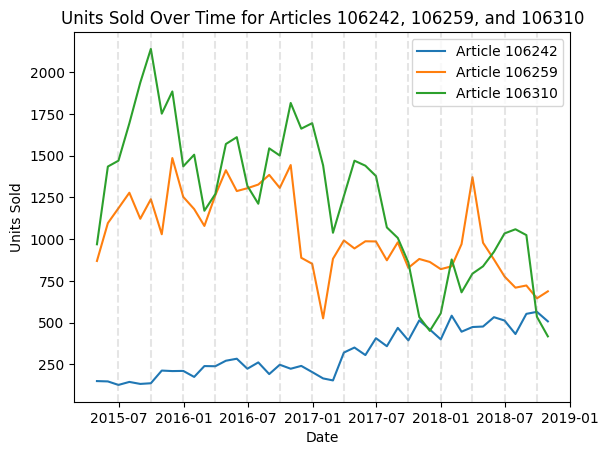

In [9]:

a = grouped_sales[grouped_sales["ARTICLE_ID"] == '106242']
b = grouped_sales[grouped_sales["ARTICLE_ID"] == '106259']
c = grouped_sales[grouped_sales["ARTICLE_ID"] == '106310']

# Create a new figure and plot the UNITS for each article on the same plot
fig, ax = plt.subplots()
ax.plot(a.index, a["UNITS"], label='Article 106242')
ax.plot(b.index, b['UNITS'], label='Article 106259')
ax.plot(c.index, c['UNITS'], label='Article 106310')


# Add a legend, x-label, y-label, and title to the plot
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Units Sold Over Time for Articles 106242, 106259, and 106310')

# Add horizontal lines at start of each quarter
quarters = pd.date_range(start=a.index.min(), end=a.index.max(), freq='Q')
for quarter in quarters:
    ax.axvline(x=quarter, color='gray', linestyle='--', alpha=0.2)

## TODO ?? 
# # Add regression lines
# temp = regression_table.head(3)
# abc_regs = pd.melt(abc, ignore_index=False)
# articles = ["106242","105259","106310"]
# for article in articles:
#     ax.plot(abc_regs, 
    
plt.show()

In [10]:
# store articles that didnt have Q2-2015 sales for now
no_sales_2015Q2 = regression_table[regression_table["Q2-2015"] == 0].index

In [25]:
# Define the number of clusters
n_clusters = 8 # originally had 15

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100).fit(regression_table)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
regression_table["cluster"] = labels

regression_table.head(5)

Q2-2015    Q3-2015   Q4-2015   Q1-2016    Q2-2016   Q3-2016  \
106242 -0.375314  -0.132569 -0.032426  1.054054  -0.780365 -0.240774   
106259  5.192225  -0.663741  3.609996  1.435579  -1.783053 -0.315657   
106310  8.250985   7.314583 -5.231996 -3.851166  -4.084558  4.770871   
106497  0.129882 -10.752239  6.253493  4.842651 -17.851666  7.777678   
106650  3.943210  11.770154 -4.594769 -0.317660  -4.087603  2.455392   

          Q4-2016   Q1-2017   Q2-2017    Q3-2017   Q4-2017   Q1-2018  \
106242  -0.332676  2.676234  0.904873   0.590290 -1.869043 -1.115959   
106259  -9.657470  7.837543  0.692404  -0.714260 -1.002150  9.119977   
106310  -1.966679 -2.936854 -1.505195  -3.434790  0.377463 -1.350746   
106497 -19.942315 -5.227325 -8.064135  13.300430 -4.947689  5.177956   
106650  -9.018094 -0.331803 -3.428162   4.808133 -2.211752  0.716992   

         Q2-2018   Q3-2018  cluster  
106242  0.596919  2.189896        0  
106259 -3.311000 -1.041025        0  
106310  3.227159 -8.565030        0  
106497 -3.995700  5.067001        0  
106650 -4.115192  3.086528        0

In [26]:
regression_table.groupby(["cluster"]).count()

Q2-2015  Q3-2015  Q4-2015  Q1-2016  Q2-2016  Q3-2016  Q4-2016  \
cluster                                                                  
0            310      310      310      310      310      310      310   
1              5        5        5        5        5        5        5   
2              2        2        2        2        2        2        2   
3             47       47       47       47       47       47       47   
4             54       54       54       54       54       54       54   
5              4        4        4        4        4        4        4   
6              5        5        5        5        5        5        5   
7              8        8        8        8        8        8        8   

         Q1-2017  Q2-2017  Q3-2017  Q4-2017  Q1-2018  Q2-2018  Q3-2018  
cluster                                                                 
0            310      310      310      310      310      310      310  
1              5        5        5        5        5        5        5  
2              2        2        2        2        2        2        2  
3             47       47       47       47       47       47       47  
4             54       54       54       54       54       54       54  
5              4        4        4        4        4        4        4  
6              5        5        5        5        5        5        5  
7              8        8        8        8        8        8        8

In [97]:
#grouped_sales = grouped_sales.reset_index()
# add cluster no. to grouped_sales table
cluster_labels = regression_table["cluster"]
cluster_labels = cluster_labels.reset_index()
cluster_labels = cluster_labels.rename(columns={"index":"ARTICLE_ID"})

clustered_sales = pd.merge(grouped_sales, cluster_labels, on="ARTICLE_ID")
clustered_sales = clustered_sales.set_index("DATE")
clustered_sales.head(3)

cluster_labels

ARTICLE_ID  cluster
0       106242        0
1       106259        0
2       106310        0
3       106497        0
4       106650        0
..         ...      ...
430      98031        0
431      98048        0
432      98065        4
433      98099        4
434      98150        4

[435 rows x 2 columns]

In [28]:
# create a function to plot clusters of time series
def plot_clustered_time_series(sales, cluster_no=0):
    '''
    sales (pd.DataFrame) *Index should be datetime datatype
    cluster_no (int) Cluster to plot
    '''
    
    temp = sales[sales["cluster"]==cluster_no]["ARTICLE_ID"].unique().tolist()
    temp_df = sales[sales["ARTICLE_ID"].isin(temp)]
    ids = temp

    fig, ax = plt.subplots()

    for id in ids:
        p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
        ax.plot(p.index, p["UNITS"], alpha=0.4, color="steelblue")
        plt.title(f"Spaghetti Plot of Cluster No.{cluster_no}")
        plt.ylim([0, 18500])

    plt.show()

## Plot Initial Clusters

[0, 3, 1, 4, 6, 5, 2, 7]


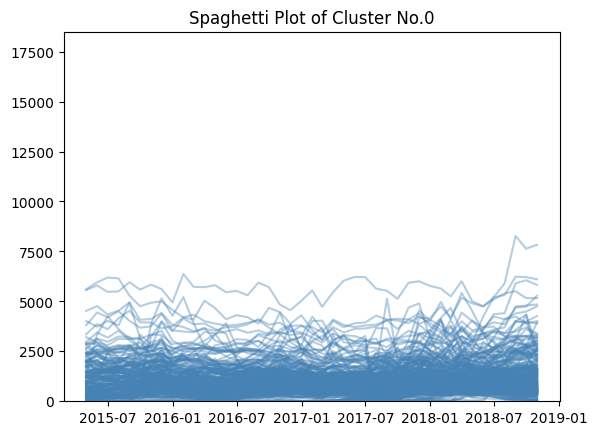

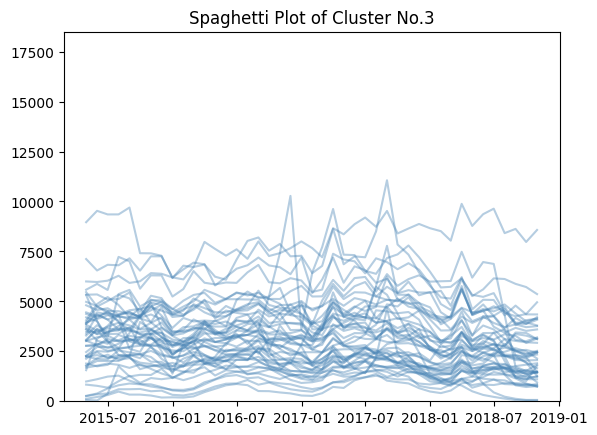

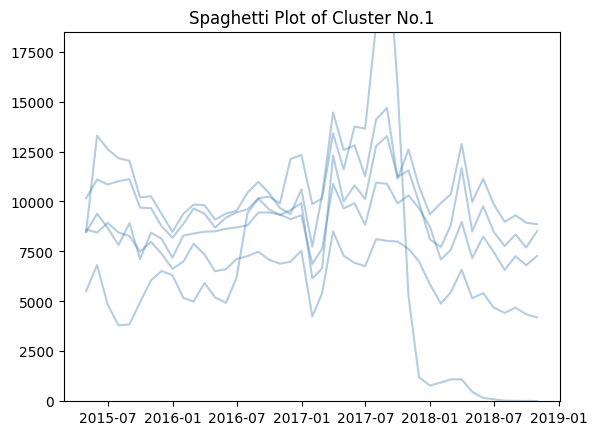

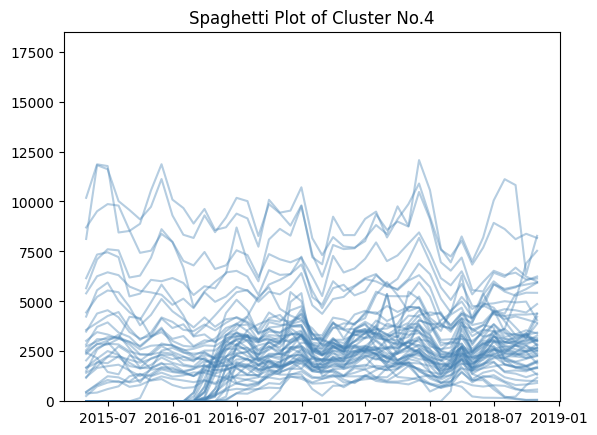

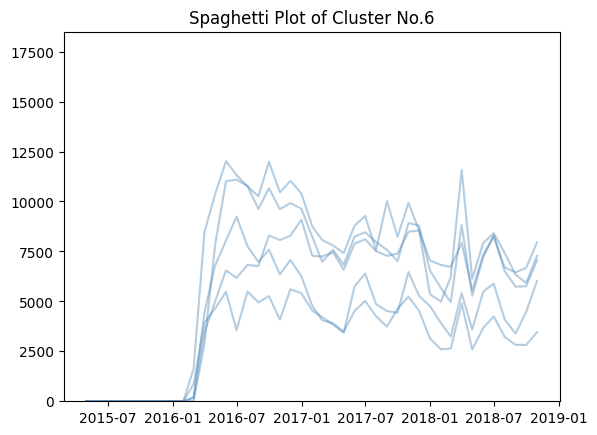

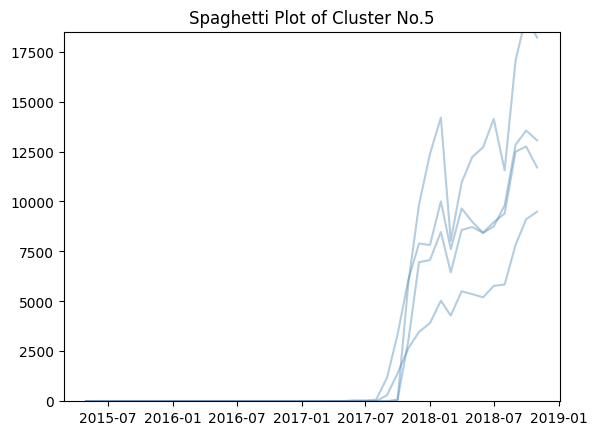

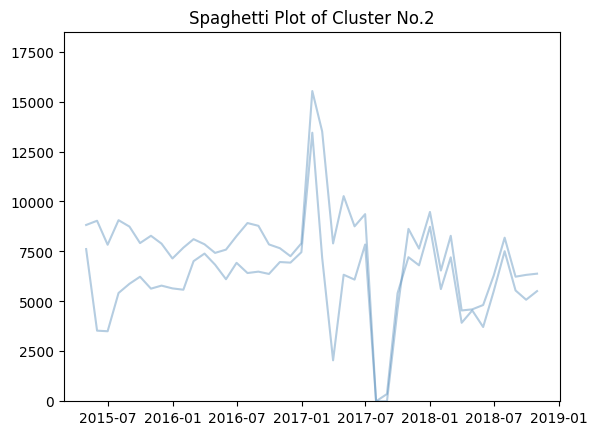

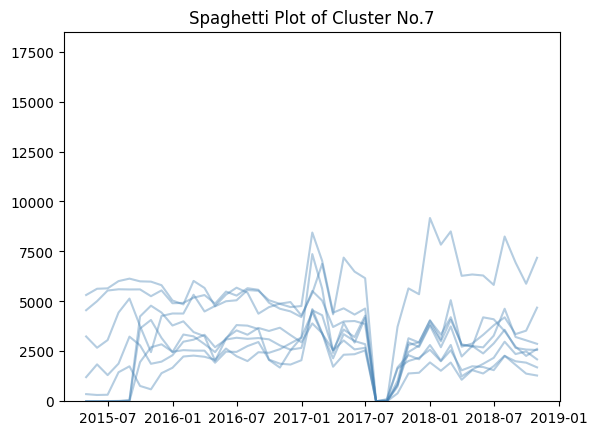

In [29]:
clusters = clustered_sales["cluster"].unique().tolist()
print(clusters)

for cluster in clusters:
    plot_clustered_time_series(clustered_sales, cluster_no=cluster)

## XGBoost on Clustered Data

In [30]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
warnings.filterwarnings("ignore")

In [31]:
def feat_target_set(df, feats=["art"], target=["units"]):
    X = df[feats]
    y = df[target]
    return X, y

In [34]:
clustered_sales

ARTICLE_ID   UNITS  cluster
DATE                                  
2015-04-30     106242   149.0        0
2015-05-31     106242   147.0        0
2015-06-30     106242   126.0        0
2015-07-31     106242   144.0        0
2015-08-31     106242   132.0        0
...               ...     ...      ...
2018-06-30      98150  3225.0        4
2018-07-31      98150  3131.0        4
2018-08-31      98150  2942.0        4
2018-09-30      98150  2842.0        4
2018-10-31      98150  3082.0        4

[18705 rows x 3 columns]

In [38]:
# Add month & year as features
temp = clustered_sales.reset_index()
temp["month"] = temp["DATE"].dt.month
temp["year"] = temp["DATE"].dt.year
temp = temp.set_index("DATE")

# Prepare train, test and validation sets
train = temp.loc[:"2018-10"]
test = temp.loc["2018-10"]
#validate = temp.loc["2018-10"]

# Set features and target
X_train, y_train = train[["ARTICLE_ID","month","cluster"]], train["UNITS"]
X_test, y_test = test[["ARTICLE_ID","month","cluster"]], test["UNITS"]
#X_validate, y_validate = validate[["ARTICLE_ID","month","cluster"]], validate["UNITS"]


if (len(X_test) == len(y_test)) & (len(X_train) == len(y_train)): 
    print("Sanity check: Test-train split lengths match.")
    
    
# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True) 
#dvalidate = xgb.DMatrix(X_test, y_test, enable_categorical=True) 

# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds = model.predict(dtest)
print("Fit complete. \n")

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

# Combine the ndarray and Series into a pandas dataframe
results = pd.DataFrame({'ARTICLE_ID': X_test["ARTICLE_ID"], "Predictions": preds, "Actuals": y_test, "AbsDiff":abs(preds-y_test), "Cluster":X_test["cluster"]})

wmape = b.get_wmape(results, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape)

Sanity check: Test-train split lengths match.
Fit complete. 

RMSE of the base model: 1408.343
WMAPE:  0.4320841599819881


### XGBoost Results Analysis

In [39]:
results["PerMiss"] = results["AbsDiff"]/results["Actuals"]*100

In [40]:
results.query("PerMiss >= 10").sort_values("PerMiss", ascending=False).head(20)

ARTICLE_ID  Predictions  Actuals      AbsDiff  Cluster  \
DATE                                                                
2018-10-31      85876  5841.312012     12.0  5829.312012        1   
2018-10-31     124721  2549.572021     36.0  2513.572021        3   
2018-10-31      84873  1537.645630     31.0  1506.645630        0   
2018-10-31       1368   645.568848     14.0   631.568848        0   
2018-10-31     146107  1658.160767     37.0  1621.160767        0   
2018-10-31      81303  1306.177490     33.0  1273.177490        0   
2018-10-31     122817  2547.929443     67.0  2480.929443        3   
2018-10-31     144441   894.547729     33.0   861.547729        0   
2018-10-31       2908   863.894775     35.0   828.894775        0   
2018-10-31     144458   949.656250     45.0   904.656250        0   
2018-10-31      11187   852.152100     43.0   809.152100        0   
2018-10-31       4971  1131.162598     61.0  1070.162598        4   
2018-10-31     146124   984.198792     58.0   926.198792        0   
2018-10-31      15556  1089.905029     79.0  1010.905029        4   
2018-10-31     144373  1046.098877     82.0   964.098877        0   
2018-10-31      25008   900.103455     91.0   809.103455        0   
2018-10-31      17885   964.270874    143.0   821.270874        0   
2018-10-31       4969  1124.270996    168.0   956.270996        0   
2018-10-31      24991  1055.568970    190.0   865.568970        0   
2018-10-31       3561   660.486389    170.0   490.486389        0   

                 PerMiss  
DATE                      
2018-10-31  48577.600098  
2018-10-31   6982.144504  
2018-10-31   4860.147193  
2018-10-31   4511.206055  
2018-10-31   4381.515585  
2018-10-31   3858.113607  
2018-10-31   3702.879766  
2018-10-31   2610.750695  
2018-10-31   2368.270787  
2018-10-31   2010.347222  
2018-10-31   1881.749069  
2018-10-31   1754.364914  
2018-10-31   1596.894468  
2018-10-31   1279.626619  
2018-10-31   1175.730338  
2018-10-31    889.124675  
2018-10-31    574.315297  
2018-10-31    569.208926  
2018-10-31    455.562616  
2018-10-31    288.521405

In [43]:
print(results["AbsDiff"].sum())
print(results["Actuals"].sum())
print(results["AbsDiff"].sum()/results["Actuals"].sum())


352785.4824371338
816474.0
0.4320841599819881


In [36]:
results.query("PerMiss < 10").sort_values("PerMiss", ascending=True)

ARTICLE_ID  Predictions  Actuals     AbsDiff  Cluster   PerMiss
DATE                                                                      
2018-10-31      23716   681.540649    681.0    0.540649        4  0.079391
2018-10-31        830  2545.752441   2543.0    2.752441        4  0.108236
2018-10-31    7012536   502.322815    503.0    0.677185        4  0.134629
2018-10-31     136094  5398.947266   5428.0   29.052734        8  0.535238
2018-10-31     146991   800.352478    795.0    5.352478        4  0.673268
2018-10-31       1814  1276.848633   1267.0    9.848633        4  0.777319
2018-10-31        831  3185.301758   3159.0   26.301758        4  0.832598
2018-10-31       3537  3109.937988   3141.0   31.062012        0  0.988921
2018-10-31     250109   607.552307    614.0    6.447693        4  1.050113
2018-10-31      14978   556.725647    564.0    7.274353        4  1.289779
2018-10-31       6172  1008.338562   1022.0   13.661438        6  1.336736
2018-10-31       2022   723.357117    713.0   10.357117        4  1.452611
2018-10-31       2013   741.123535    755.0   13.876465        4  1.837942
2018-10-31       2801  1439.901611   1413.0   26.901611        0  1.903865
2018-10-31      97946  8119.541504   8280.0  160.458496        8  1.937905
2018-10-31       3418   715.085938    730.0   14.914062        0  2.043022
2018-10-31      97929  1532.932251   1499.0   33.932251        4  2.263659
2018-10-31      17902  1556.589478   1595.0   38.410522        4  2.408183
2018-10-31      98099  3117.265137   3042.0   75.265137        8  2.474199
2018-10-31      11612   581.697266    598.0   16.302734        4  2.726210
2018-10-31       3428  2706.053955   2632.0   74.053955        2  2.813600
2018-10-31       3448  2957.184814   2875.0   82.184814        2  2.858602
2018-10-31       1221   700.196716    679.0   21.196716        4  3.121755
2018-10-31      98150  2981.881348   3082.0  100.118652        8  3.248496
2018-10-31       2091   694.942688    672.0   22.942688        4  3.414090
2018-10-31       2017   519.455688    500.0   19.455688        4  3.891138
2018-10-31      97827  4088.737793   3935.0  153.737793        8  3.906932
2018-10-31     136060  2932.078857   2819.0  113.078857        8  4.011311
2018-10-31      15607  1949.317505   2033.0   83.682495        8  4.116207
2018-10-31        840  1712.384155   1786.0   73.615845        4  4.121828
2018-10-31        826  5381.550293   5161.0  220.550293        4  4.273402
2018-10-31    7099717  4735.143555   4955.0  219.856445        0  4.437062
2018-10-31      26784  2806.414795   2687.0  119.414795        8  4.444168
2018-10-31      15046   767.840149    805.0   37.159851        4  4.616131
2018-10-31      15199  1856.146118   1957.0  100.853882        8  5.153494
2018-10-31     191282  1079.617188   1026.0   53.617188        4  5.225847
2018-10-31       2805   793.320129    838.0   44.679871        4  5.331727
2018-10-31      97997  6276.584473   5945.0  331.584473        8  5.577535
2018-10-31       6410   818.530151    867.0   48.469849        4  5.590525
2018-10-31     108860   555.400269    590.0   34.599731        4  5.864361
2018-10-31      97980  3599.571533   3398.0  201.571533        8  5.932064
2018-10-31       6070  2488.110107   2647.0  158.889893        6  6.002640
2018-10-31      14791   630.829773    593.0   37.829773        4  6.379388
2018-10-31        452   823.226196    885.0   61.773804        4  6.980091
2018-10-31       6036  1664.919067   1556.0  108.919067        6  6.999940
2018-10-31      14859  2121.566650   1982.0  139.566650        8  7.041708
2018-10-31      12853   750.695251    809.0   58.304749        4  7.207015
2018-10-31      11782   691.866699    746.0   54.133301        4  7.256475
2018-10-31       2836   976.642029    909.0   67.642029        4  7.441367
2018-10-31        462  1635.336914   1770.0  134.663086        4  7.608084
2018-10-31      12394   447.655090    486.0   38.344910        4  7.889899
2018-10-31     189769  3738.801270  

In [61]:
temp = regression_table[regression_table["cluster"]==4]
cluster_4_table = temp
cluster_4_table

Q2-2015    Q3-2015   Q4-2015   Q1-2016    Q2-2016   Q3-2016  \
106242 -0.375314  -0.132569 -0.032426  1.054054  -0.780365 -0.240774   
106259  5.192225  -0.663741  3.609996  1.435579  -1.783053 -0.315657   
106310  8.250985   7.314583 -5.231996 -3.851166  -4.084558  4.770871   
106497  0.129882 -10.752239  6.253493  4.842651 -17.851666  7.777678   
106650  3.943210  11.770154 -4.594769 -0.317660  -4.087603  2.455392   
...          ...        ...       ...       ...        ...       ...   
97878   5.036725  -9.313329 -1.402902  4.543688   2.603010 -1.800251   
97929   0.679685  -8.572017  2.279291  7.065161   5.696166 -6.183088   
98031   3.070226   2.392332 -1.705482 -0.383377  -2.280186  1.077392   
98048  -1.206198  -4.020244 -2.228950  3.343576   3.639556 -1.071838   
98065   8.983160 -13.540129  2.261197  3.699000   4.140631 -1.534217   

          Q4-2016   Q1-2017   Q2-2017    Q3-2017   Q4-2017   Q1-2018  \
106242  -0.332676  2.676234  0.904873   0.590290 -1.869043 -1.115959   
106259  -9.657470  7.837543  0.692404  -0.714260 -1.002150  9.119977   
106310  -1.966679 -2.936854 -1.505195  -3.434790  0.377463 -1.350746   
106497 -19.942315 -5.227325 -8.064135  13.300430 -4.947689  5.177956   
106650  -9.018094 -0.331803 -3.428162   4.808133 -2.211752  0.716992   
...           ...       ...       ...        ...       ...       ...   
97878   -1.582945  4.748565  5.757793  -1.527051 -0.962917  5.429392   
97929   -0.856145  6.708955  1.316374  -5.179147 -1.706557  3.439150   
98031    1.000179  0.659587 -2.154783  -0.201362  0.896274 -2.369690   
98048   -2.545683  4.368542  2.984952  -3.914905 -1.603547  4.675660   
98065    4.027768 -2.948335  6.993013  -4.203870 -2.850412  2.524110   

         Q2-2018   Q3-2018  cluster  
106242  0.596919  2.189896        4  
106259 -3.311000 -1.041025        4  
106310  3.227159 -8.565030        4  
106497 -3.995700  5.067001        4  
106650 -4.115192  3.086528        4  
...          ...       ...      ...  
97878   2.709423 -2.273916        4  
97929   5.055357 -8.723038        4  
98031   2.807775 -1.417951        4  
98048   3.616804 -4.020602        4  
98065   7.360265  0.403619        4  

[287 rows x 15 columns]

## XGBoost on Clustered Data, Using Weekly Sampling

In [77]:
# Group the rows by ARTICLE_ID and month of DATE, and sum the UNITS values
temp = sales.groupby(["ARTICLE_ID", pd.Grouper(key="DATE", freq="D")])["UNITS"].sum().reset_index()
temp["DATE"] = pd.to_datetime(temp["DATE"])
weekly_sales = temp

In [78]:
cluster_labels = regression_table["cluster"]
cluster_labels = cluster_labels.reset_index()
cluster_labels = cluster_labels["index"].rename("ARTICLE_ID")
cluster_labels

0      106242
1      106259
2      106310
3      106497
4      106650
        ...  
430     98031
431     98048
432     98065
433     98099
434     98150
Name: ARTICLE_ID, Length: 435, dtype: category
Categories (435, object): ['106242', '106259', '106310', '106497', ..., '98048', '98065', '98099', '98150']

In [109]:
# Split train-test on October 2018
temp = weekly_sales_clustered
temp = temp.set_index("DATE")
train = temp.loc[:"2018-09"]
test = temp.loc["2018-10"]
#validate = temp.loc["2018-10"]

# Add week & year as features
train["week"] = train.index.week
train["year"] = train.index.year
train = train.reset_index("DATE").drop(["DATE"], axis=1)

test["week"] = test.index.week
test["year"] = test.index.year
test = test.reset_index("DATE").drop(["DATE"], axis=1)

# Add cluster labels
train = pd.merge(train, cluster_labels, on="ARTICLE_ID")
test = pd.merge(test, cluster_labels, on="ARTICLE_ID")

# Set features and target
X_train, y_train = train[["ARTICLE_ID","week","year","cluster"]], train["UNITS"]
X_test, y_test = test[["ARTICLE_ID","week","year","cluster"]], test["UNITS"]
#X_validate, y_validate = validate[["ARTICLE_ID","month","cluster"]], validate["UNITS"]

if (len(X_test) == len(y_test)) & (len(X_train) == len(y_train)): 
    print("Sanity check: Test-train split lengths match.")
    
    
# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True) 
#dvalidate = xgb.DMatrix(X_test, y_test, enable_categorical=True) 

# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds = model.predict(dtest)
print("Fit complete. \n")

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

# Combine the ndarray and Series into a pandas dataframe
results_weekly = pd.DataFrame({'ARTICLE_ID': X_test["ARTICLE_ID"], "Predictions": preds, "Actuals": y_test, "AbsDiff":abs(preds-y_test), "Week":X_test["week"], "Year":X_test["year"], "Cluster":X_test["cluster"]})

wmape = b.get_wmape(results_weekly, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape)

Sanity check: Test-train split lengths match.
Fit complete. 

RMSE of the base model: 29.480
WMAPE:  0.32694931670966754


In [115]:
train.query("ARTICLE_ID == '106242'")

ARTICLE_ID  UNITS  week  year  cluster
0        106242    2.0    14  2015        0
1        106242    6.0    14  2015        0
2        106242    9.0    14  2015        0
3        106242    5.0    14  2015        0
4        106242    0.0    14  2015        0
...         ...    ...   ...   ...      ...
1274     106242   22.0    39  2018        0
1275     106242   25.0    39  2018        0
1276     106242   16.0    39  2018        0
1277     106242   29.0    39  2018        0
1278     106242   12.0    39  2018        0

[1279 rows x 5 columns]

In [117]:
results_weekly.query("ARTICLE_ID == '106242'")

ARTICLE_ID  Predictions  Actuals    AbsDiff  Week  Year  Cluster
0      106242    15.039911      4.0  11.039911    40  2018        0
1      106242    15.039911     18.0   2.960089    40  2018        0
2      106242    15.039911      8.0   7.039911    40  2018        0
3      106242    15.039911     38.0  22.960089    40  2018        0
4      106242    15.039911     10.0   5.039911    40  2018        0
5      106242    15.039911     15.0   0.039911    40  2018        0
6      106242    15.039911     22.0   6.960089    40  2018        0
7      106242    14.018696     17.0   2.981304    41  2018        0
8      106242    14.018696     26.0  11.981304    41  2018        0
9      106242    14.018696     15.0   0.981304    41  2018        0
10     106242    14.018696     21.0   6.981304    41  2018        0
11     106242    14.018696     30.0  15.981304    41  2018        0
12     106242    14.018696     16.0   1.981304    41  2018        0
13     106242    14.018696     18.0   3.981304    41  2018        0
14     106242    17.681303     13.0   4.681303    42  2018        0
15     106242    17.681303     22.0   4.318697    42  2018        0
16     106242    17.681303     19.0   1.318697    42  2018        0
17     106242    17.681303     21.0   3.318697    42  2018        0
18     106242    17.681303     15.0   2.681303    42  2018        0
19     106242    17.681303     20.0   2.318697    42  2018        0
20     106242    17.681303      3.0  14.681303    42  2018        0
21     106242    17.238977      9.0   8.238977    43  2018        0
22     106242    17.238977     11.0   6.238977    43  2018        0
23     106242    17.238977     30.0  12.761023    43  2018        0
24     106242    17.238977     21.0   3.761023    43  2018        0
25     106242    17.238977     10.0   7.238977    43  2018        0
26     106242    17.238977     12.0   5.238977    43  2018        0
27     106242    17.238977      9.0   8.238977    43  2018        0
28     106242    15.317305      7.0   8.317305    44  2018        0
29     106242    15.317305     19.0   3.682695    44  2018        0
30     106242    15.317305      8.0   7.317305    44  2018        0

In [135]:
# Group by ARTICLE_ID and Cluster, and sum up Predictions and Actuals
temp = results_weekly[["ARTICLE_ID","Predictions","Actuals"]]
temp = temp.groupby(['ARTICLE_ID']).agg({'Predictions': 'sum', 'Actuals': 'sum'}).reset_index()
results_weekly_grouped = pd.merge(temp, cluster_labels, on="ARTICLE_ID")
results_weekly_grouped['AbsDiff'] = abs(results_weekly_grouped['Actuals']-results_weekly_grouped['Predictions'])

wmape = b.get_wmape(results_weekly_grouped, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape)

results_weekly_grouped


WMAPE:  0.2206784281858447


ARTICLE_ID  Predictions  Actuals  cluster     AbsDiff
0       106242   493.804138    507.0        0   13.195862
1       106259   544.796143    687.0        0  142.203857
2       106310   441.351379    417.0        0   24.351379
3       106497  1762.516113   1412.0        0  350.516113
4       106650   745.876648    573.0        0  172.876648
..         ...          ...      ...      ...         ...
430      98031   178.974854    295.0        0  116.025146
431      98048   582.309814    653.0        0   70.690186
432      98065  2194.729736   1887.0        4  307.729736
433      98099  2706.335938   3042.0        4  335.664062
434      98150  2677.356934   3082.0        4  404.643066

[435 rows x 5 columns]

In [147]:
grouped_sales

DATE ARTICLE_ID   UNITS
0     2015-04-30     106242   149.0
1     2015-05-31     106242   147.0
2     2015-06-30     106242   126.0
3     2015-07-31     106242   144.0
4     2015-08-31     106242   132.0
...          ...        ...     ...
18700 2018-06-30      98150  3225.0
18701 2018-07-31      98150  3131.0
18702 2018-08-31      98150  2942.0
18703 2018-09-30      98150  2842.0
18704 2018-10-31      98150  3082.0

[18705 rows x 3 columns]

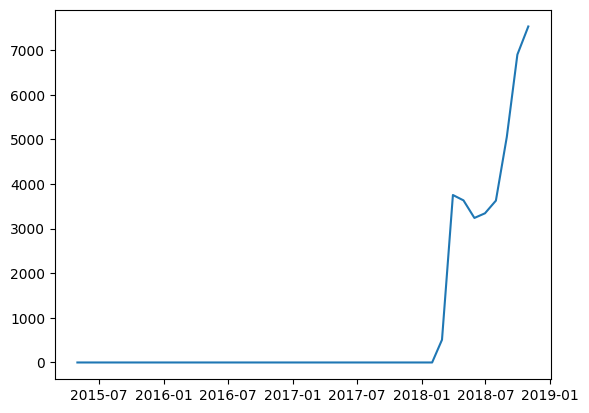

In [158]:
temp = grouped_sales.set_index("DATE")
temp = temp[temp["ARTICLE_ID"] == '7788']

fig, ax = plt.subplots()
ax.plot(temp.index, temp["UNITS"], label='Article 7788')

plt.show()

In [169]:
results_weekly_grouped.query("cluster == 0").sort_values("AbsDiff", ascending=False).head(30)

ARTICLE_ID  Predictions  Actuals  cluster      AbsDiff
281       4030  4994.622070   7831.0        0  2836.377930
226       3351  1159.120483   3957.0        0  2797.879517
275       4013  3496.222168   1374.0        0  2122.222168
9       112345  2923.035156    829.0        0  2094.035156
278       4020  4302.296875   6105.0        0  1802.703125
279       4022  3824.600586   2100.0        0  1724.600586
291       4058  2779.830078   4267.0        0  1487.169922
344       6258  3909.468018   5290.0        0  1380.531982
273       4002  4524.966309   5821.0        0  1296.033691
123      15301   937.743408   2212.0        0  1274.256592
342       6255  2644.912598   3899.0        0  1254.087402
77        1419  1594.025635   2728.0        0  1133.974365
335       6240  3180.214111   2104.0        0  1076.214111
192      24991  1254.705933    190.0        0  1064.705933
82        1427  3694.897461   4755.0        0  1060.102539
287       4046  2248.972900   3297.0        0  1048.027100
310       4915   598.794495   1622.0        0  1023.205505
261       3767  1346.560303   2368.0        0  1021.439697
193      25008  1112.174072     91.0        0  1021.174072
221       3065  1159.120483    204.0        0   955.120483
325       6070  3549.083252   2647.0        0   902.083252
282       4032  1337.513428    447.0        0   890.513428
83        1428  2129.013428   3001.0        0   871.986572
323       6019  1570.932617    708.0        0   862.932617
391      84873   892.884705     31.0        0   861.884705
345       6308  1192.140747    334.0        0   858.140747
374      81303   889.341797     33.0        0   856.341797
274       4012  4022.301514   4849.0        0   826.698486
148      18004  2537.384521   3336.0        0   798.615479
223       3193  1159.120483    364.0        0   795.120483

In [142]:
true_monthly_sales = grouped_sales.groupby(['ARTICLE_ID', pd.Grouper(key='DATE', freq='M')])['UNITS'].sum().reset_index()
true_monthly_sales.set_index("DATE").loc["2018-10"]

ARTICLE_ID   UNITS
DATE                         
2018-10-31     106242   507.0
2018-10-31     106259   687.0
2018-10-31     106310   417.0
2018-10-31     106497  1412.0
2018-10-31     106650   573.0
...               ...     ...
2018-10-31      98031   295.0
2018-10-31      98048   653.0
2018-10-31      98065  1887.0
2018-10-31      98099  3042.0
2018-10-31      98150  3082.0

[435 rows x 2 columns]

## Error articles

In [191]:
with open("error_msg.json_v2") as json_file:
    error_msg = json.load(json_file)

error_articles = list(error_msg.keys())
error_articles

['1408',
 '15454',
 '15539',
 '15046',
 '14876',
 '14995',
 '15352',
 '1814',
 '15556',
 '15369',
 '15641',
 '15658',
 '15386',
 '1427',
 '1400',
 '3561',
 '15012',
 '1411',
 '1421',
 '4042',
 '3051',
 '4012',
 '4070',
 '184',
 '181',
 '1435',
 '3065',
 '4022',
 '3024',
 '182',
 '6258',
 '4058',
 '1404',
 '2360',
 '6251',
 '6252',
 '4020',
 '4034',
 '189',
 '6254',
 '4046',
 '3036',
 '3816',
 '4040',
 '6253',
 '14808',
 '4054',
 '4028',
 '6505',
 '4915',
 '3068',
 '4002',
 '3019',
 '6699',
 '3767',
 '122',
 '113',
 '12394',
 '185',
 '6249',
 '1414',
 '1416',
 '1402',
 '6255',
 '3034',
 '1432',
 '6256',
 '4068',
 '4062',
 '4032',
 '4030',
 '4044',
 '3351',
 '15216',
 '14978',
 '4050',
 '4014',
 '118',
 '7788',
 '3040',
 '3812',
 '4018',
 '187',
 '3030',
 '4263',
 '3058',
 '6241',
 '6128',
 '2928',
 '33',
 '3042',
 '12275']

In [195]:
cluster_labels.query("ARTICLE_ID == @error_articles")

ARTICLE_ID  cluster
10         113        0
22         118        0
30         122        0
36       12275        0
43       12394        0
58        1400        0
59        1402        0
65        1404        0
68        1408        4
70        1411        4
72        1414        0
74        1416        0
78        1421        0
82        1427        0
85        1432        0
86        1435        0
101      14808        4
104      14876        0
108      14978        0
109      14995        4
110      15012        4
112      15046        0
121      15216        0
125      15352        4
126      15369        4
127      15386        0
130      15454        0
134      15539        0
135      15556        4
138      15641        0
139      15658        4
149        181        0
150       1814        0
151        182        0
152        184        0
153        185        0
155        187        0
156        189        0
188       2360        0
211       2928        0
212       3019        5
213       3024        0
214       3030        0
215       3034        0
216       3036        0
217       3040        0
218       3042        0
219       3051        0
220       3058        0
221       3065        0
222       3068        0
225         33        0
226       3351        0
255       3561        0
261       3767        0
263       3812        0
264       3816        5
273       4002        0
274       4012        0
276       4014        0
277       4018        0
278       4020        0
279       4022        0
280       4028        0
281       4030        0
282       4032        0
283       4034        0
284       4040        0
285       4042        0
286       4044        0
287       4046        0
289       4050        0
290       4054        0
291       4058        0
292       4062        0
293       4068        0
294       4070        0
295       4263        0
310       4915        0
328       6128        0
336       6241        0
337       6249        0
338       6251        5
339       6252        5
340       6253        0
341       6254        0
342       6255        0
343       6256        0
344       6258        0
348       6505        4
354       6699        0
373       7788        4

In [196]:
grouped_sales

DATE ARTICLE_ID   UNITS
0     2015-04-30     106242   149.0
1     2015-05-31     106242   147.0
2     2015-06-30     106242   126.0
3     2015-07-31     106242   144.0
4     2015-08-31     106242   132.0
...          ...        ...     ...
18700 2018-06-30      98150  3225.0
18701 2018-07-31      98150  3131.0
18702 2018-08-31      98150  2942.0
18703 2018-09-30      98150  2842.0
18704 2018-10-31      98150  3082.0

[18705 rows x 3 columns]

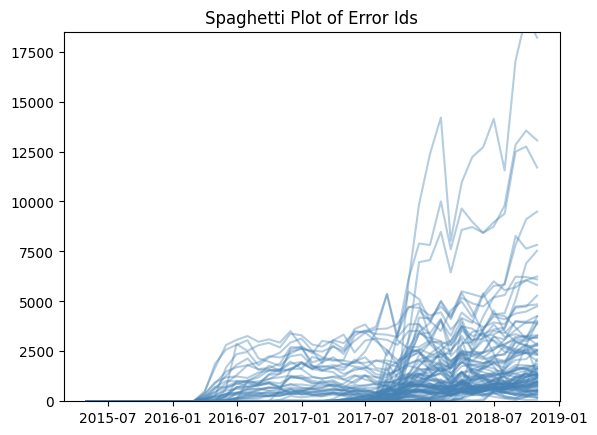

In [199]:
temp = grouped_sales.set_index("DATE")

fig, ax = plt.subplots()


for id in error_articles:
    p = temp[temp['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"], alpha=0.4, color="steelblue")
    plt.title(f"Spaghetti Plot of Error Ids")
    plt.ylim([0, 18500])

plt.show()

## TODO 

In [63]:
# Define the number of clusters
n_clusters = 3

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100).fit(cluster_4_table)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
cluster_4_table["cluster_lvl_2"] = labels


# add cluster lvl 2 no. to grouped_sales table
cluster_lvl_2_labels = cluster_4_table["cluster_lvl_2"]
cluster_lvl_2_labels = cluster_lvl_2_labels.reset_index()
cluster_lvl_2_labels = cluster_lvl_2_labels.rename(columns={"index":"ARTICLE_ID"})

clustered_sales = pd.merge(clustered_sales, cluster_lvl_2_labels, on="ARTICLE_ID") ## TODO - need to fix merge to handle clusters != 4
clustered_sales.head(3)

ARTICLE_ID  UNITS  cluster  cluster_lvl_2
0     106242  149.0        4              0
1     106242  147.0        4              0
2     106242  126.0        4              0

In [71]:
clustered_sales

ARTICLE_ID   UNITS  cluster  cluster_lvl_2
0         106242   149.0        4              0
1         106242   147.0        4              0
2         106242   126.0        4              0
3         106242   144.0        4              0
4         106242   132.0        4              0
...          ...     ...      ...            ...
12336      98065  2604.0        4              2
12337      98065  2457.0        4              2
12338      98065  2799.0        4              2
12339      98065  2478.0        4              2
12340      98065  1887.0        4              2

[12341 rows x 4 columns]

In [70]:
ids = cluster_4_table["ARTICLE_ID"].unique().tolist()

fig, ax = plt.subplots()

for id in ids:
    p = clustered_sales.loc[clustered_sales['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

KeyError: 'ARTICLE_ID'

## Impute values for missing November 2017 sales

In [174]:
temp = clustered_sales.query("cluster == 2 | cluster == 3")
ids_impute = temp["ARTICLE_ID"].unique().tolist()

clustered_sales_imputed = clustered_sales.copy()

for article_id in ids_impute:
    article_data = clustered_sales_imputed.loc[clustered_sales_imputed['ARTICLE_ID'] == article_id]
    article_data['UNITS'] = article_data['UNITS'].replace(0, pd.np.nan)
    article_data['UNITS'] = article_data['UNITS'].interpolate(method='linear',limit_direction='both')
    clustered_sales_imputed.loc[clustered_sales_imputed['ARTICLE_ID'] == article_id] = article_data

clustered_sales_imputed.query("cluster == 2 | cluster == 3").loc["2017-9"]

ARTICLE_ID   UNITS  cluster
DATE                                  
2017-09-30       3419   791.0        2
2017-09-30       3428   705.0        2
2017-09-30       3429  5408.0        3
2017-09-30       3430  1701.0        2
2017-09-30       3431  4601.0        3
2017-09-30       3432   738.0        2
2017-09-30       3434   826.0        2
2017-09-30       3438  3730.0        2
2017-09-30       3439   404.0        2
2017-09-30       3442  1019.0        2
2017-09-30       3444   403.0        2
2017-09-30       3447  1638.0        2
2017-09-30       3448   846.0        2
2017-09-30       3449   397.0        2

In [177]:
# Add month & year as features
temp = clustered_sales_imputed.reset_index()
temp["month"] = temp["DATE"].dt.month
temp["year"] = temp["DATE"].dt.year
temp = temp.set_index("DATE")

# Prepare train, test and validation sets
train = temp.loc[:"2018-10"]
test = temp.loc["2018-10"]
#validate = temp.loc["2018-10"]

# Set features and target
X_train, y_train = train[["ARTICLE_ID","month","cluster"]], train["UNITS"]
X_test, y_test = test[["ARTICLE_ID","month","cluster"]], test["UNITS"]
#X_validate, y_validate = validate[["ARTICLE_ID","month","cluster"]], validate["UNITS"]


if (len(X_test) == len(y_test)) & (len(X_train) == len(y_train)): 
    print("Sanity check: Test-train split lengths match.")
    
    
# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True) 
#dvalidate = xgb.DMatrix(X_test, y_test, enable_categorical=True) 

# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds = model.predict(dtest)
print("Fit complete. \n")

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

# Combine the ndarray and Series into a pandas dataframe
results_02 = pd.DataFrame({'ARTICLE_ID': X_test["ARTICLE_ID"], "Predictions": preds, "Actuals": y_test, "AbsDiff":abs(preds-y_test), "Cluster":X_test["cluster"]})

wmape_02 = b.get_wmape(results_02, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape_02)

Sanity check: Test-train split lengths match.
Fit complete. 

RMSE of the base model: 1429.953
WMAPE:  0.4345191921908165


In [185]:
results_02["PerMiss"] = results_02["AbsDiff"]/results_02["Actuals"]*100
results_02.query("PerMiss >= 10").sort_values("PerMiss", ascending=False)

ARTICLE_ID  Predictions  Actuals      AbsDiff  Cluster  \
DATE                                                                
2018-10-31      85876  5905.071289     12.0  5893.071289        7   
2018-10-31     124721  2356.678955     36.0  2320.678955        0   
2018-10-31      84873  1656.378540     31.0  1625.378540        4   
2018-10-31       1368   635.139771     14.0   621.139771        4   
2018-10-31     146107  1595.339478     37.0  1558.339478        4   
...               ...          ...      ...          ...      ...   
2018-10-31     250109   680.733154    614.0    66.733154        4   
2018-10-31       2011  2018.200195   2258.0   239.799805        8   
2018-10-31       2091   602.405762    672.0    69.594238        4   
2018-10-31     140344  1775.332642   1611.0   164.332642        4   
2018-10-31       2013   678.355286    755.0    76.644714        4   

                 PerMiss  
DATE                      
2018-10-31  49108.927409  
2018-10-31   6446.330431  
2018-10-31   5243.156581  
2018-10-31   4436.712646  
2018-10-31   4211.728318  
...                  ...  
2018-10-31     10.868592  
2018-10-31     10.620009  
2018-10-31     10.356285  
2018-10-31     10.200661  
2018-10-31     10.151618  

[376 rows x 6 columns]

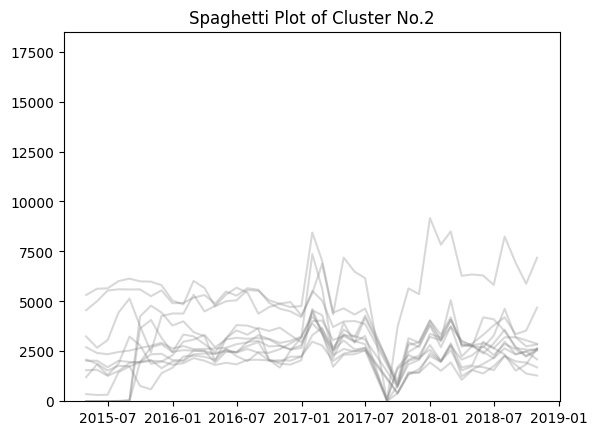

In [187]:
plot_clustered_time_series(clustered_sales_imputed, cluster_no=2)

# TODO - Fix Interpolation

In [ ]:
# Group the rows by ARTICLE_ID and week of DATE, and sum the UNITS values
temp = sales.groupby(['ARTICLE_ID', pd.Grouper(key='DATE', freq='D')])['UNITS'].sum().reset_index()
temp["DATE"] = pd.to_datetime(temp["DATE"])
temp = pd.merge(temp, cluster_labels, on="ARTICLE_ID")
temp = temp.set_index("DATE")
sales_impute = temp

temp = clustered_sales.query("cluster == 2 | cluster == 3")
ids_impute = temp["ARTICLE_ID"].unique().tolist()


for article_id in ids_impute:
    article_data = sales_impute.loc[sales_impute['ARTICLE_ID'] == article_id]
    article_data['UNITS'] = article_data['UNITS'].replace(range(0,11), pd.np.nan)
    sales_impute.loc[sales_impute['ARTICLE_ID'] == article_id] = article_data

fig, ax = plt.subplots()

for id in ids:
    p = sales_impute.loc[(sales_impute['ARTICLE_ID'] == id) & (sales_impute['cluster'] == 2)]
    ax.plot(p.index, p["UNITS"], alpha=0.3, color="gray")
    plt.title(f"Spaghetti Plot of Cluster No. 2 After Removing 0 Values")

plt.show()

# for article_id in sales_impute['ARTICLE_ID'].unique():
#     article_data = sales_impute.loc[sales_impute['ARTICLE_ID'] == article_id]
#     article_data['UNITS'] = article_data['UNITS'].fillna(method='ffill').fillna(method='bfill').interpolate(method='linear', limit_direction='both')
#     sales_impute.loc[sales_impute['ARTICLE_ID'] == article_id] = article_data

for article_id in sales_impute['ARTICLE_ID'].unique():
    article_data = sales_impute.loc[sales_impute['ARTICLE_ID'] == article_id]
    article_data['UNITS'] = article_data['UNITS'].fillna(method='ffill').rolling(7, center=True).apply(lambda x: x.interpolate(method='linear'))
    sales_impute.loc[sales_impute['ARTICLE_ID'] == article_id] = article_data

fig, ax = plt.subplots()

for id in ids:
    p = sales_impute.loc[(sales_impute['ARTICLE_ID'] == id) & (sales_impute['cluster'] == 2)]
    ax.plot(p.index, p["UNITS"], alpha=0.3, color="gray")
    plt.title(f"Spaghetti Plot of Cluster No. 2 After Imputation")

plt.show()


There seems to be improvement after imputing the missing values.

## XGBoost with Cross Validation

In [ ]:
# Add month & year as features
temp = clustered_sales.reset_index()
temp["month"] = temp["DATE"].dt.month
temp["year"] = temp["DATE"].dt.year
temp = temp.set_index("DATE")

# Prepare train, test and validation sets
train = temp.loc[:"2018-09"]
test = temp.loc["2018-09"]
validate = temp.loc["2018-10"]

# Set features and target
X_train, y_train = train[["ARTICLE_ID","month","cluster"]], train["UNITS"]
X_test, y_test = test[["ARTICLE_ID","month","cluster"]], test["UNITS"]
X_validate, y_validate = validate[["ARTICLE_ID","month","cluster"]], validate["UNITS"]


if (len(X_test) == len(y_test)) & (len(X_train) == len(y_train)): 
    print("Sanity check: Test-train split lengths match.")
    
    
# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True) 
#dvalidate = xgb.DMatrix(X_test, y_test, enable_categorical=True) 

# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds = model.predict(dtest)
print("Fit complete. \n")

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

# Combine the ndarray and Series into a pandas dataframe
results = pd.DataFrame({'ARTICLE_ID': X_test["ARTICLE_ID"], "Predictions": preds, "Actuals": y_test, "AbsDiff":abs(preds-y_test), "Cluster":X_test["cluster"]})

wmape = b.get_wmape(results, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape)

## CLEAN UP / DELETE

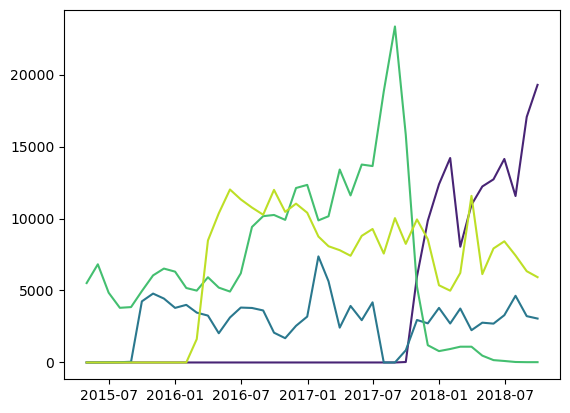

In [46]:
fig, ax = plt.subplots()

cluster_3 = grouped_sales[grouped_sales["ARTICLE_ID"] == '6251']
cluster_7 = grouped_sales[grouped_sales["ARTICLE_ID"] == '3448']
cluster_8 = grouped_sales[grouped_sales["ARTICLE_ID"] == '85876']
cluster_12 = grouped_sales[grouped_sales["ARTICLE_ID"] == '15148']
ax.plot(cluster_3.index, cluster_3["UNITS"], color=viridis(0.1), label='Article 6251')
ax.plot(cluster_7.index, cluster_7["UNITS"], color=viridis(0.4), label='Article 3448')
ax.plot(cluster_8.index, cluster_8["UNITS"], color=viridis(0.7), label='Article 85876')
ax.plot(cluster_12.index, cluster_12["UNITS"], color=viridis(0.9), label='Article 85876')

plt.show()

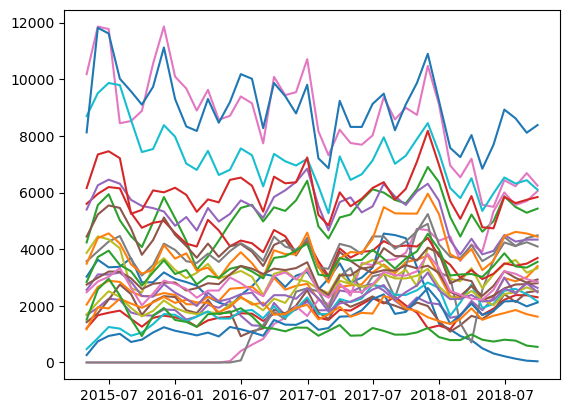

In [64]:
temp = regression_table[regression_table["cluster"]==0].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
reg_table_cluster_0 = regression_table[regression_table["cluster"]==0]

## Can cluster 0 be improved?

In [65]:
# Define the number of clusters
n_clusters = 3
random_seed = 20

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=100).fit(reg_table_cluster_0)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
reg_table_cluster_0["cluster"] = labels

/var/folders/jc/57b2n61s3sgd__mz5yq9vvmc0000gn/T/ipykernel_73708/65528883.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_table_cluster_0["cluster"] = labels


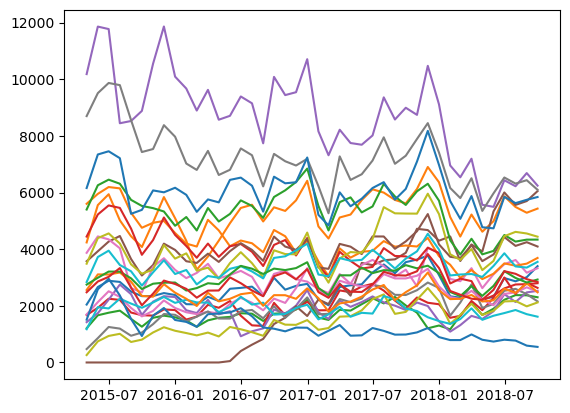

In [66]:
temp = reg_table_cluster_0[reg_table_cluster_0["cluster"]==0].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

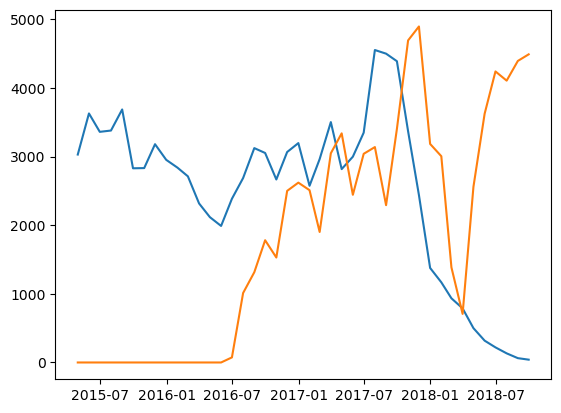

In [67]:
temp = reg_table_cluster_0[reg_table_cluster_0["cluster"]==1].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

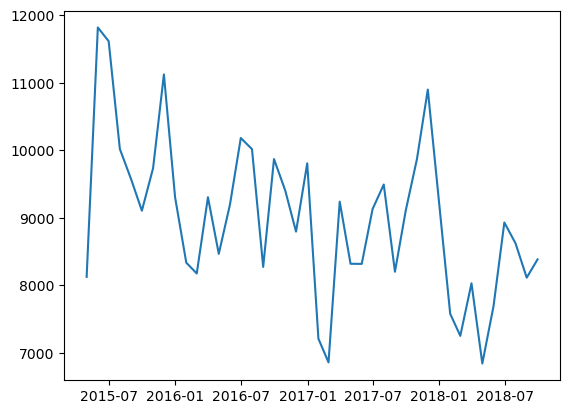

In [68]:
temp = reg_table_cluster_0[reg_table_cluster_0["cluster"]==2].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

## Cluster = 1

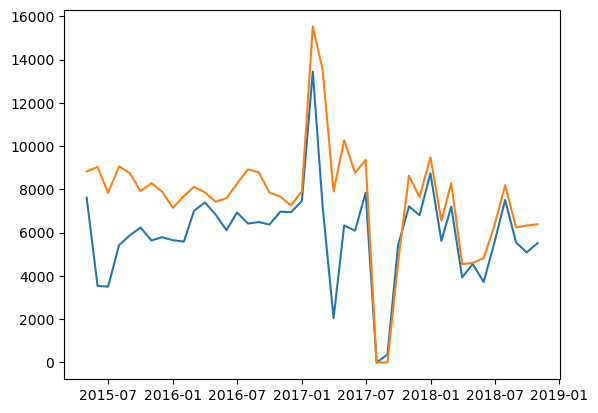

In [95]:
temp = regression_table[regression_table["cluster"]==1].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store ids
missing_sales_2017Q3 = ids

# store cluster regression table & articles as a variable
reg_table_cluster_1 = regression_table[regression_table["cluster"]==1]

### Store articles with missing sales in 2017

In [ ]:
missing_sales_2017Q3

## Cluster = 2

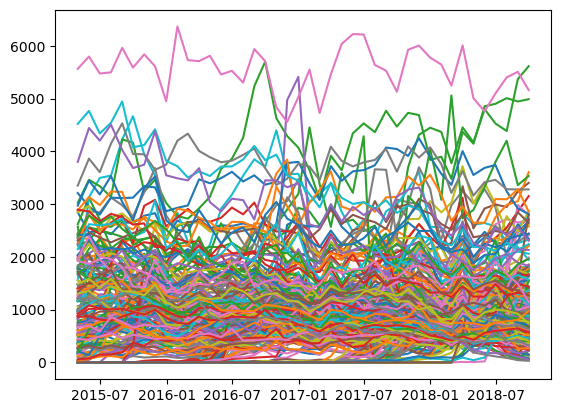

In [70]:
temp = regression_table[regression_table["cluster"]==2].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
reg_table_cluster_2 = regression_table[regression_table["cluster"]==2]

## Additional clustering

In [71]:
# Define the number of clusters
n_clusters = 4
random_seed = 20

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=100).fit(reg_table_cluster_2)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
reg_table_cluster_2["cluster"] = labels

reg_table_cluster_2.head(5)

/var/folders/jc/57b2n61s3sgd__mz5yq9vvmc0000gn/T/ipykernel_73708/2853315959.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_table_cluster_2["cluster"] = labels


Q2-2015   Q3-2015   Q4-2015   Q1-2016   Q2-2016   Q3-2016   Q4-2016  \
106242 -0.375314 -0.132569 -0.032426  1.054054 -0.780365 -0.240774 -0.332676   
106259  5.192225 -0.663741  3.609996  1.435579 -1.783053 -0.315657 -9.657470   
106310  8.250985  7.314583 -5.231996 -3.851166 -4.084558  4.770871 -1.966679   
108860  2.201182  1.069151 -1.335364 -0.483710  2.110176  4.221605 -0.127374   
108894  4.400036  3.811716 -5.333930 -3.521288  5.915263  6.772662  5.919563   

         Q1-2017   Q2-2017   Q3-2017   Q4-2017   Q1-2018   Q2-2018   Q3-2018  \
106242  2.676234  0.904873  0.590290 -1.869043 -1.115959  0.596919  2.189896   
106259  7.837543  0.692404 -0.714260 -1.002150  9.119977 -3.311000 -1.041025   
106310 -2.936854 -1.505195 -3.434790  0.377463 -1.350746  3.227159 -8.565030   
108860  1.538462 -0.416159  3.214260  2.708886  0.671642  3.283232  5.420459   
108894 -0.208955  0.721247  5.278753  0.173952  2.105052  7.978144  1.719993   

        cluster  
106242        0  
106259        2  
106310        0  
108860        0  
108894        0

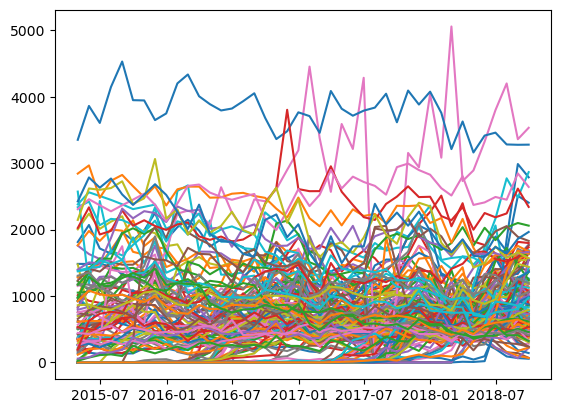

In [72]:
temp = reg_table_cluster_2[reg_table_cluster_2["cluster"]==0].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])


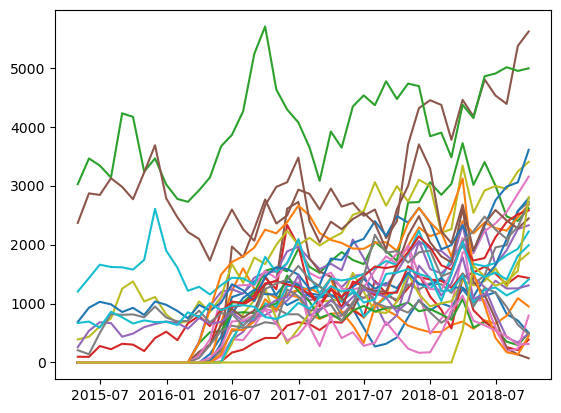

In [73]:
temp = reg_table_cluster_2[reg_table_cluster_2["cluster"]==1].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])


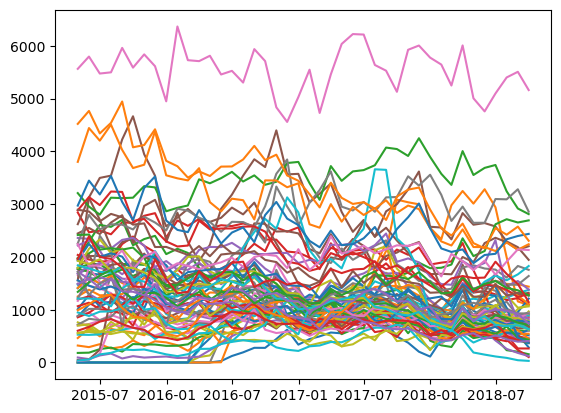

In [74]:
temp = reg_table_cluster_2[reg_table_cluster_2["cluster"]==2].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])


## Cluster = 3

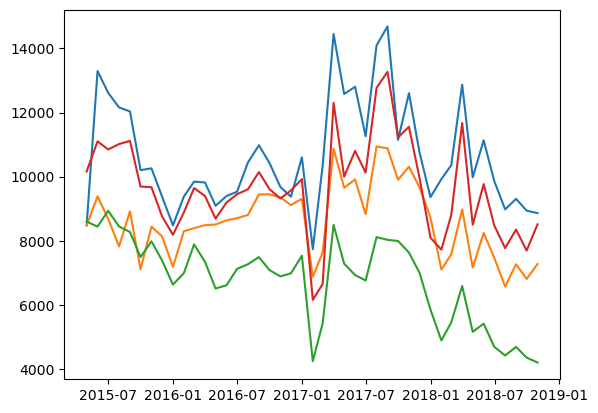

In [96]:
# TODO - add these articles to missing data 2017Q3 list
temp = regression_table[regression_table["cluster"]==3].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

## Cluster = 4

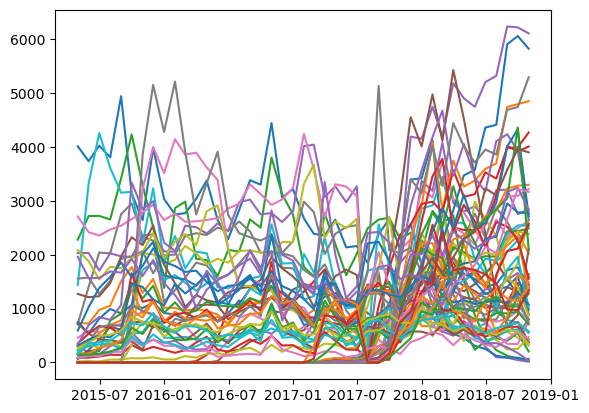

In [16]:
temp = regression_table[regression_table["cluster"]==4].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

# store cluster regression table & articles as a variable
reg_table_cluster_4 = regression_table[regression_table["cluster"]==4]

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

### Apply clustering on cluster=4

In [17]:
reg_table_cluster_4 = reg_table_cluster_4.drop(["cluster"], axis=1)

In [23]:
# Define the number of clusters
n_clusters = 4
random_seed = 20

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=100).fit(reg_table_cluster_4)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
reg_table_cluster_4["cluster"] = labels

reg_table_cluster_4.head(5)

Q2-2015    Q3-2015    Q4-2015    Q1-2016    Q2-2016   Q3-2016  \
106497  0.129882 -10.752239   6.253493   4.842651 -17.851666  7.777678   
106650  3.943210  11.770154  -4.594769  -0.317660  -4.087603  2.455392   
122817  7.284486  25.861698 -31.387854 -15.862088   3.028305  7.328556   
12360   0.000000   0.000000   0.000000   0.421140  14.692583  6.228771   
1368   -2.764421   4.106593   0.169832  -2.702518   2.274095  1.298459   

          Q4-2016    Q1-2017    Q2-2017    Q3-2017    Q4-2017   Q1-2018  \
106497 -19.942315  -5.227325  -8.064135  13.300430  -4.947689  5.177956   
106650  -9.018094  -0.331803  -3.428162   4.808133  -2.211752  0.716992   
122817 -17.266392  17.202641  -3.103547   3.175206  -4.304550 -1.265212   
12360   -4.775708   6.937428 -19.241849  -0.309029  11.882838  7.232491   
1368     0.188463   8.149828  -2.075958   8.755643   4.290039 -5.756028   

          Q2-2018   Q3-2018  cluster  
106497  -3.995700  5.067001        2  
106650  -4.115192  3.086528        2  
122817 -17.887137 -2.659799        1  
12360   -0.498925  5.521856        0  
1368    -7.822465 -0.865460        0

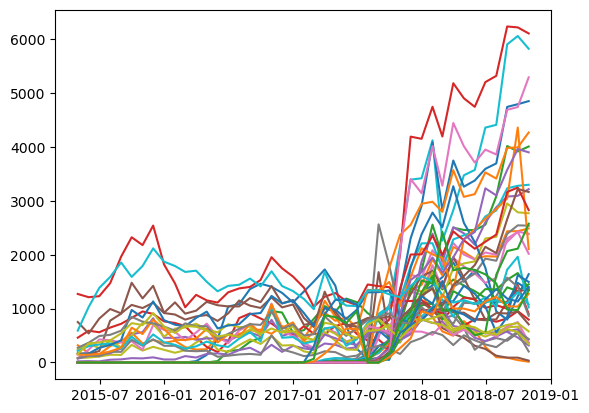

In [24]:
temp = reg_table_cluster_4[reg_table_cluster_4["cluster"]==0].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

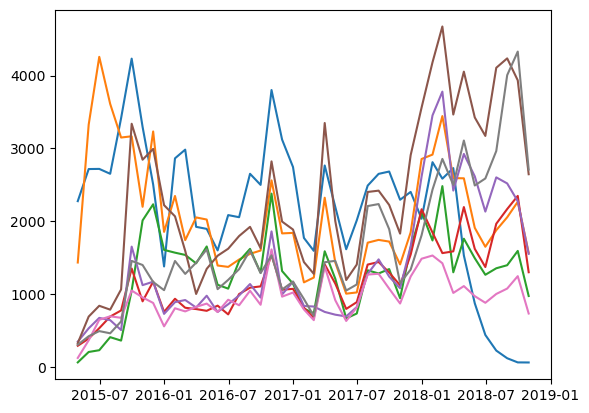

In [25]:
temp = reg_table_cluster_4[reg_table_cluster_4["cluster"]==1].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

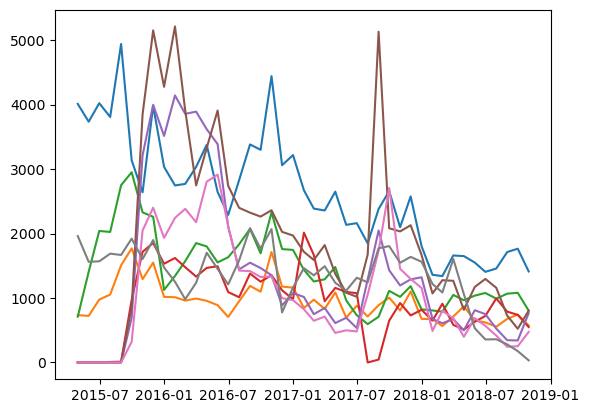

In [26]:
temp = reg_table_cluster_4[reg_table_cluster_4["cluster"]==2].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

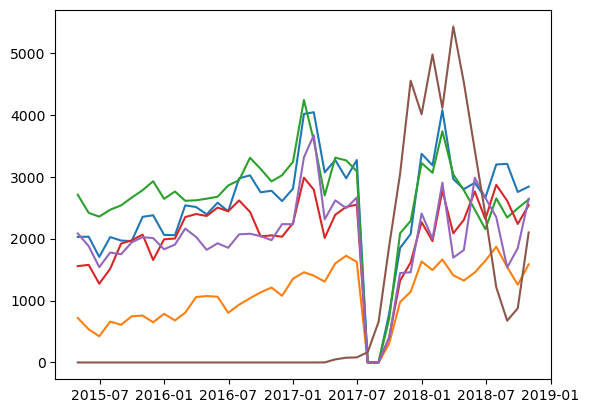

In [27]:
temp = reg_table_cluster_4[reg_table_cluster_4["cluster"]==3].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

## Cluster = 5

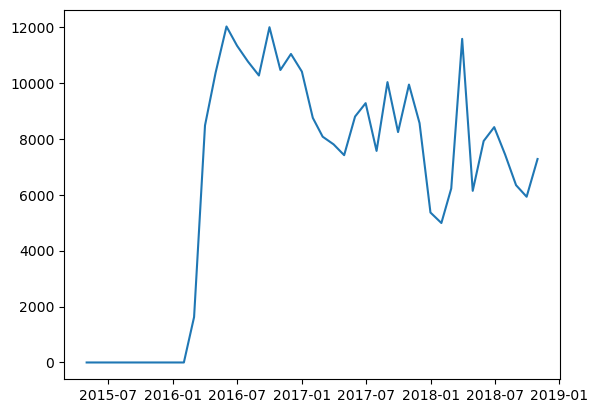

In [23]:
temp = regression_table[regression_table["cluster"]==5].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

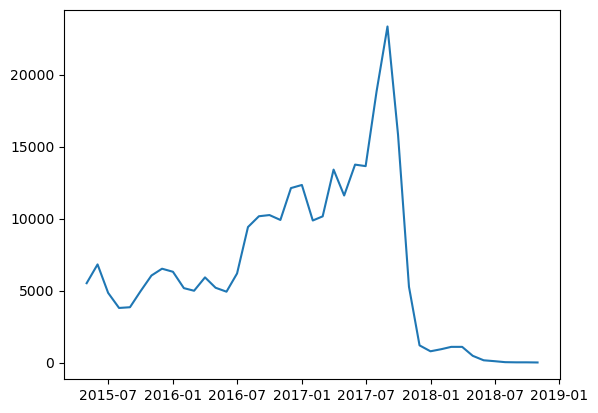

In [24]:
temp = regression_table[regression_table["cluster"]==6].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store ids
ids_cluster6 = ids

In [26]:
ids

['6251']

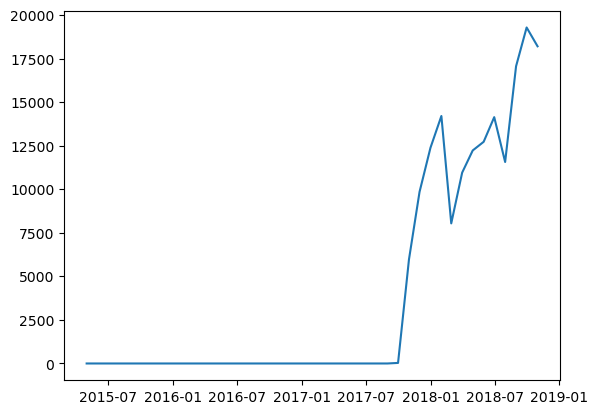

In [25]:
temp = regression_table[regression_table["cluster"]==7].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

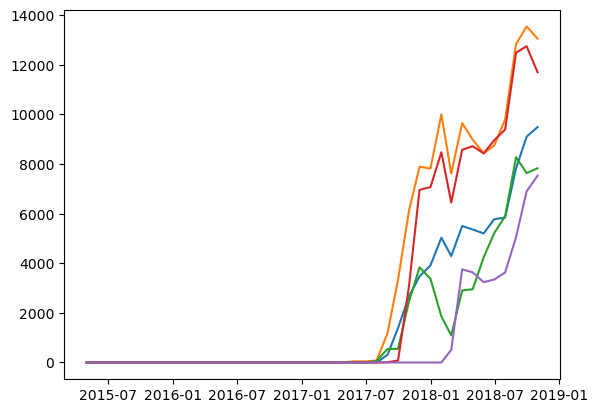

['3019', '3816', '4030', '6252', '7788']


In [27]:
temp = regression_table[regression_table["cluster"]==8].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()
print(ids)

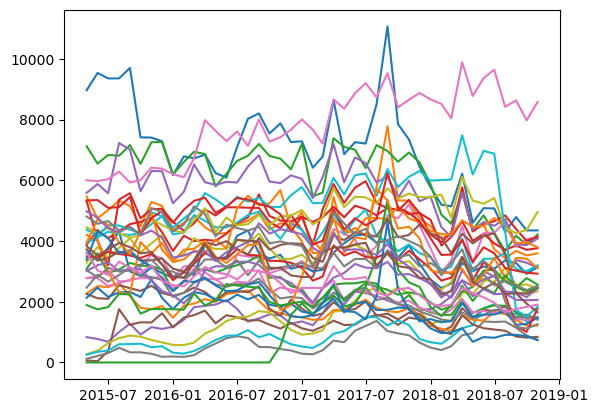

In [28]:
temp = regression_table[regression_table["cluster"]==9].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

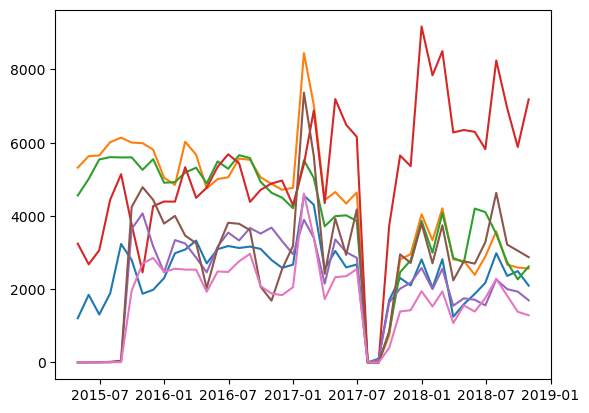

In [29]:
temp = regression_table[regression_table["cluster"]==10].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

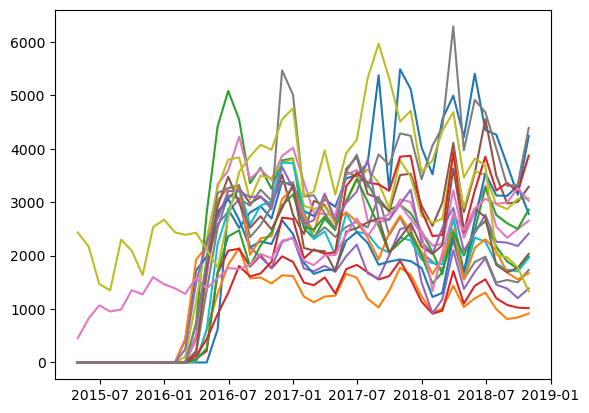

In [30]:
temp = regression_table[regression_table["cluster"]==11].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

In [31]:
regression_table[regression_table["cluster"]==1]

Q2-2015    Q3-2015    Q4-2015    Q1-2016    Q2-2016    Q3-2016  \
3429 -67.799713  13.352741   0.170727  29.944280   1.385883  -0.721068   
3431 -16.101576 -18.740236 -18.652454   2.705665  13.772304 -17.484772   

       Q4-2016     Q1-2017    Q2-2017    Q3-2017    Q4-2017    Q1-2018  \
3429  8.114296 -192.597015  24.638123  88.261913  25.173952 -29.964983   
3431  4.109638 -130.172790 -14.975636  75.007345  14.136869 -35.407003   

        Q2-2018    Q3-2018  cluster  
3429  15.517736 -39.934253        1  
3431  27.655142 -30.688463        1

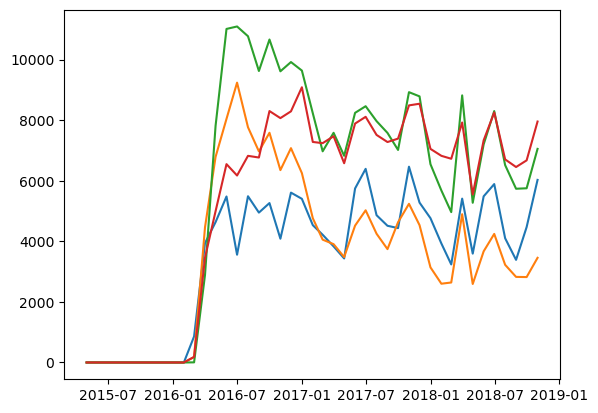

In [32]:
temp = regression_table[regression_table["cluster"]==12].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

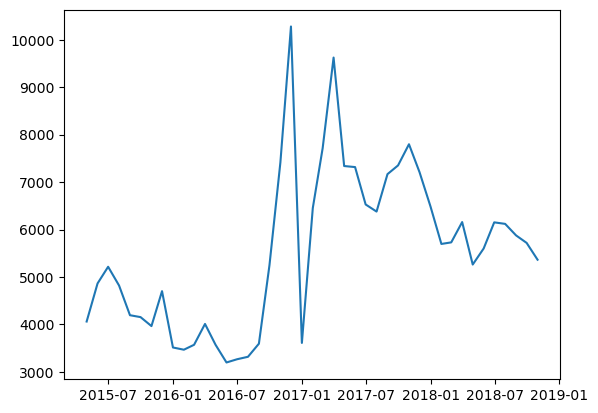

In [33]:
temp = regression_table[regression_table["cluster"]==13].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

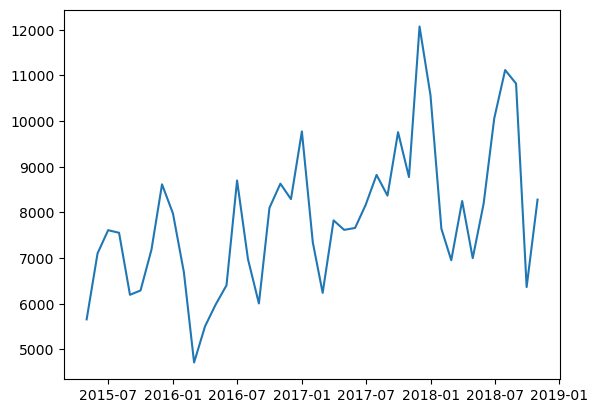

In [34]:
temp = regression_table[regression_table["cluster"]==14].index.values.tolist()
temp_df = grouped_sales[grouped_sales["ARTICLE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['ARTICLE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

## XGBoost

Save cluster labels

### Try k-means using algorithm="elkan"?

In [ ]:
grouped_sales.set_index("DATE").loc["2018-11-04"]

In [ ]:
results = pd.DataFrame({'Article': X_test["ARTICLE_ID"], 'cluster':X_test['cluster'], 'Predictions': preds, 'Actuals': y_test, 'AbsDiff':abs(preds-y_test), 'Perc':abs(preds-y_test)/y_test})

In [ ]:
results.sort_values("AbsDiff", ascending=False).head(20)

In [ ]:
results.sort_values("AbsDiff", ascending=False).query("Perc <= .10")

In [ ]:
61/435

In [ ]:
regression_table[regression_table["ARTICLE_ID"]=="6251"]
regression_table[regression_table["cluster"]==9]

# notice that articles clusters 3 and 9 are at top of the worst predictions

In [ ]:
from flaml import AutoML
from flaml.automl.data import load_openml_dataset

automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
    "task": 'regression',  # task type
    "log_file_name": 'cluster_articles_experiment.log',  # flaml log file
    "seed": 7654321,  # random seed
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

In [ ]:
print(automl.model.estimator)

In [ ]:
from flaml.automl.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=settings["log_file_name"], time_budget=120)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation Accuracy")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()

In [ ]:
# print feature importance
import matplotlib.pyplot as plt
plt.barh(automl.model.estimator.feature_name_, automl.model.estimator.feature_importances_)

### XGBoost with Cross Validation

To Dos: 

- [ ] Further clustering on specific article groups

- [ ] Test XGBoost using CV

## Location Clustering

In [106]:
def compute_stores_quarterly_regression(sales):
    """Computes the linear regression for each quarter for each unique article in the sales dataset.

    Args:
        sales (pd.DataFrame): The sales dataset.
        feature (str): Column in the dataset to loop through.

    Returns:
        pd.DataFrame: A table with the slope values for each quarter for each unique article.
    """
    from sklearn.linear_model import LinearRegression
    
    # Create a new dataframe with one row for each unique ARTICLE_ID and one column for each quarter
    quarterly_reg = pd.DataFrame(index=sales['STORE_ID'].unique())

    # Loop through each quarter and compute the regression for each ARTICLE_ID
    for year in range(sales.index.year.min(), sales.index.year.max() + 1):
        for quarter in range(1, 5):
            start_date = pd.to_datetime(f'{year}-01-01') + pd.DateOffset(months=(quarter-1)*3)
            end_date = start_date + pd.DateOffset(months=3) - pd.DateOffset(days=1)
            quarter_name = f'Q{quarter}-{year}'

            # Filter the sales dataset to only include data for the current quarter
            sales_q = sales.loc[(sales.index >= start_date) & (sales.index <= end_date)]

            # Loop through each unique ARTICLE_ID and compute the regression
            for store_id in sales['STORE_ID'].unique():
                sales_q_filtered = sales_q.loc[sales_q['STORE_ID'] == store_id]

                if len(sales_q_filtered) > 1:
                    X = sales_q_filtered.index.to_julian_date().values.reshape(-1, 1)
                    y = sales_q_filtered['UNITS'].values.reshape(-1, 1)
                    model = LinearRegression().fit(X, y)
                    quarterly_reg.loc[store_id, quarter_name] = model.coef_[0][0]

    return quarterly_reg


In [118]:
geocoords = pd.read_csv("lat_lng.csv")

In [100]:
# Read-in data
stores = pd.read_csv("store.csv", sep="|",
                    usecols=["STORE_ID","ZIP_CODE","STATE_CODE"], 
                    dtype={"STORE_ID":"category","ZIP_CODE":int,"STATE_CODE":"category"},
                    low_memory=False)
sales = pd.read_csv("final_sales.csv", parse_dates=["DATE"], 
                    usecols=["ARTICLE_ID","DATE","UNITS","STORE_ID"], 
                    dtype={"ARTICLE_ID":"category","UNITS":np.float64,"STORE_ID":"category"},
                    low_memory=False)

# Sort
sales.sort_values(by=["DATE","ARTICLE_ID"], inplace=True)

# Group the rows by ARTICLE_ID and month of DATE, and sum the UNITS values
temp = sales.groupby(['STORE_ID', pd.Grouper(key='DATE', freq='M')])['UNITS'].sum().reset_index()
temp["DATE"] = pd.to_datetime(temp["DATE"])
temp = temp.set_index("DATE")
grouped_sales = temp.loc[(temp.index <= "2018-10")]
grouped_sales

STORE_ID  UNITS
DATE                      
2015-04-30    10014   92.0
2015-05-31    10014  160.0
2015-06-30    10014  130.0
2015-07-31    10014  108.0
2015-08-31    10014  108.0
...             ...    ...
2018-05-31     9997  460.0
2018-06-30     9997  422.0
2018-07-31     9997  474.0
2018-08-31     9997  640.0
2018-09-30     9997  524.0

[97020 rows x 2 columns]

In [101]:
grouped_sales = grouped_sales.reset_index()
grouped_sales_stores = pd.merge(grouped_sales, stores, on="STORE_ID")

In [102]:
grouped_sales_stores = grouped_sales_stores.set_index("DATE")

In [107]:
regression_table_stores = compute_stores_quarterly_regression(sales=grouped_sales_stores)
regression_table_stores.head(3)

Q2-2015   Q3-2015   Q4-2015   Q1-2016   Q2-2016   Q3-2016   Q4-2016  \
105309 -0.536725 -0.193837 -1.223217  2.905591  1.959692 -1.827123 -1.079900   
105317  0.505374 -0.449660 -0.483698  1.380044  1.024901  1.323898  0.498209   
105473  0.483877  0.043712  0.686492 -0.370974  1.766929 -0.750448 -0.671623   

         Q1-2017   Q2-2017   Q3-2017   Q4-2017   Q1-2018   Q2-2018   Q3-2018  
105309  2.246843 -0.423504 -1.086886 -3.195450  0.717566  0.145826  0.672698  
105317  0.920207  1.979756  0.101039 -1.351845  1.354765 -0.438373 -0.603010  
105473  0.138921 -0.372447 -0.814403 -0.214439  1.792767 -0.378001  1.199212

In [161]:
# Define the number of clusters
n_clusters = 100

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100).fit(regression_table_stores)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
regression_table_stores["cluster"] = labels

regression_table_stores.head(5)

Q2-2015   Q3-2015   Q4-2015   Q1-2016   Q2-2016   Q3-2016   Q4-2016  \
105309 -0.536725 -0.193837 -1.223217  2.905591  1.959692 -1.827123 -1.079900   
105317  0.505374 -0.449660 -0.483698  1.380044  1.024901  1.323898  0.498209   
105473  0.483877  0.043712  0.686492 -0.370974  1.766929 -0.750448 -0.671623   
105481  1.107130  0.312075 -1.510928 -0.655868  0.713544  1.340738 -1.266034   
105961  1.538696  0.540308 -1.692583  0.609589  2.021856 -1.099606 -0.371014   

         Q1-2017   Q2-2017   Q3-2017   Q4-2017   Q1-2018   Q2-2018   Q3-2018  \
105309  2.246843 -0.423504 -1.086886 -3.195450  0.717566  0.145826  0.672698   
105317  0.920207  1.979756  0.101039 -1.351845  1.354765 -0.438373 -0.603010   
105473  0.138921 -0.372447 -0.814403 -0.214439  1.792767 -0.378001  1.199212   
105481  0.971297 -0.985489  1.018631 -3.505374  0.462687  2.735041 -3.902186   
105961 -9.411596  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        cluster  
105309       50  
105317       29  
105473       70  
105481       73  
105961       63

In [162]:
regression_table_stores.groupby(["cluster"]).count()

Q2-2015  Q3-2015  Q4-2015  Q1-2016  Q2-2016  Q3-2016  Q4-2016  \
cluster                                                                  
0              1        1        1        1        1        1        1   
1             11       11       11       11       11       11       11   
2             11       11       11       11       11       11       11   
3             27       27       27       27       27       27       27   
4             20       20       20       20       20       20       20   
...          ...      ...      ...      ...      ...      ...      ...   
95             1        1        1        1        1        1        1   
96             5        5        5        5        5        5        5   
97             1        1        1        1        1        1        1   
98             2        2        2        2        2        2        2   
99            43       43       43       43       43       43       43   

         Q1-2017  Q2-2017  Q3-2017  Q4-2017  Q1-2018  Q2-2018  Q3-2018  
cluster                                                                 
0              1        1        1        1        1        1        1  
1             11       11       11       11       11       11       11  
2             11       11       11       11       11       11       11  
3             27       27       27       27       27       27       27  
4             20       20       20       20       20       20       20  
...          ...      ...      ...      ...      ...      ...      ...  
95             1        1        1        1        1        1        1  
96             5        5        5        5        5        5        5  
97             1        1        1        1        1        1        1  
98             2        2        2        2        2        2        2  
99            43       43       43       43       43       43       43  

[100 rows x 14 columns]

In [ ]:
import folium

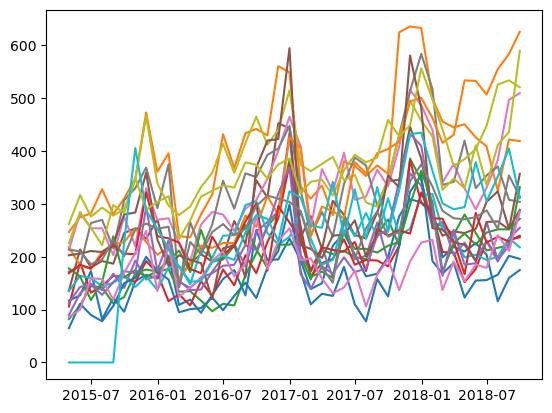

In [173]:
temp = regression_table_stores[regression_table_stores["cluster"]==9].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_9 = regression_table_stores[regression_table_stores["cluster"]==9]

temp = regression_table_stores_9.index.values.tolist()
stores_cluster_9 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_9, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


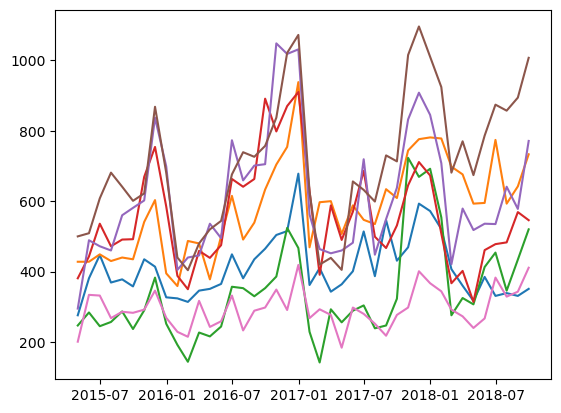

In [177]:
temp = regression_table_stores[regression_table_stores["cluster"]==12].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_12 = regression_table_stores[regression_table_stores["cluster"]==12]

temp = regression_table_stores_12.index.values.tolist()
stores_cluster_12 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_12, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


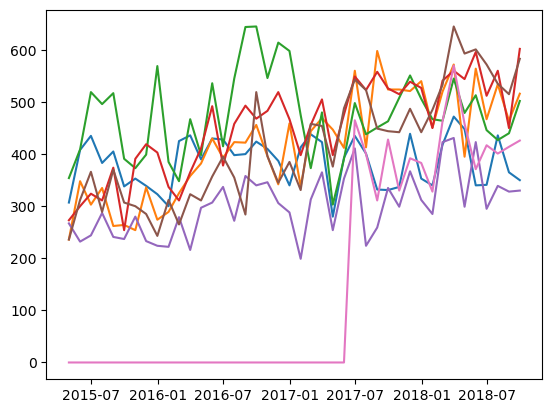

In [178]:
temp = regression_table_stores[regression_table_stores["cluster"]==13].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_13 = regression_table_stores[regression_table_stores["cluster"]==13]

temp = regression_table_stores_13.index.values.tolist()
stores_cluster_13 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_13, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


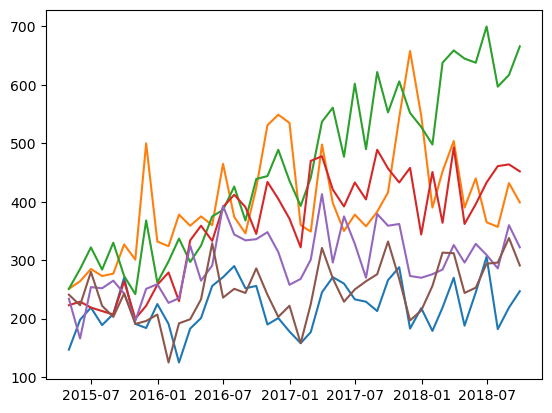

In [179]:
temp = regression_table_stores[regression_table_stores["cluster"]==14].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_14 = regression_table_stores[regression_table_stores["cluster"]==14]

temp = regression_table_stores_14.index.values.tolist()
stores_cluster_14 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_14, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


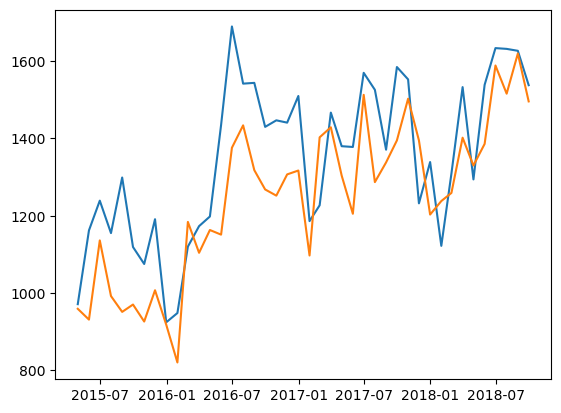

In [182]:
temp = regression_table_stores[regression_table_stores["cluster"]==15].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_15 = regression_table_stores[regression_table_stores["cluster"]==15]

temp = regression_table_stores_15.index.values.tolist()
stores_cluster_15 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_15, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


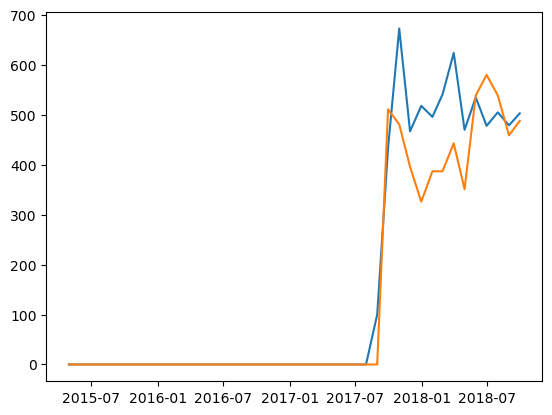

In [187]:
temp = regression_table_stores[regression_table_stores["cluster"]==18].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_18 = regression_table_stores[regression_table_stores["cluster"]==18]

temp = regression_table_stores_18.index.values.tolist()
stores_cluster_18 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_18, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


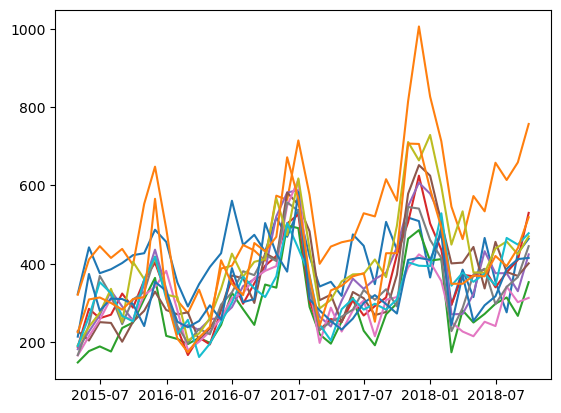

In [196]:
temp = regression_table_stores[regression_table_stores["cluster"]==26].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_26 = regression_table_stores[regression_table_stores["cluster"]==26]

temp = regression_table_stores_26.index.values.tolist()
stores_cluster_26 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_26, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


['227575', '244226', '267365', '353429', '599506', '646091']


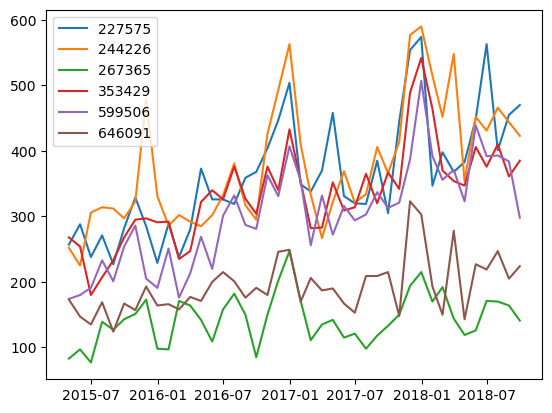

In [222]:
temp = regression_table_stores[regression_table_stores["cluster"]==38].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp
print(ids)
fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"], label=id)
    ax.legend()

plt.show()


# store cluster regression table & articles as a variable
regression_table_stores_38 = regression_table_stores[regression_table_stores["cluster"]==38]

temp = regression_table_stores_38.index.values.tolist()
stores_cluster_38 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_38, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


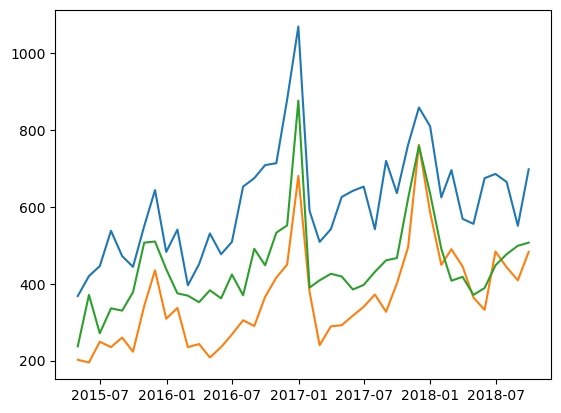

In [206]:
temp = regression_table_stores[regression_table_stores["cluster"]==42].index.values.tolist()
temp_df = grouped_sales_stores[grouped_sales_stores["STORE_ID"].isin(temp)]
ids = temp

fig, ax = plt.subplots()

for id in ids:
    p = temp_df.loc[temp_df['STORE_ID'] == id]
    ax.plot(p.index, p["UNITS"])

plt.show()

# store cluster regression table & articles as a variable
regression_table_stores_42 = regression_table_stores[regression_table_stores["cluster"]==42]

temp = regression_table_stores_42.index.values.tolist()
stores_cluster_42 = stores[stores["STORE_ID"].isin(temp)]

temp = pd.merge(stores_cluster_42, geocoords, on="ZIP_CODE")
temp = temp[["LAT","LNG"]].values.tolist()

# Create a map centered on the United States
us_map = folium.Map(location=[39.50, -98.35], zoom_start=4)

# Add markers for each location using its latitude and longitude
locations =  temp # example coordinates
for loc in locations:
    folium.Marker(location=loc).add_to(us_map)

# Display the map
us_map


### Impute NA values

#### TODO - Imputing with the mean probably not a great method here. Instead, could break up years into quarters and avoid NAs entirely. 

In [ ]:
# Calculate the mean of each row
row_means = slopes_df.mean(axis=1)

# Loop through each row and fill in empty values with row mean
for i, row in slopes_df.iterrows():
    empty_indices = row[row.isnull()].index
    slopes_df.loc[i, empty_indices] = row_means[i]

slopes_df.head(5)

In [ ]:
slopes_df.isnull().any()

In [ ]:
# Define the number of clusters
n_clusters = 4

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(slopes_df)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
slopes_df["cluster"] = labels

slopes_df.head(5)

In [ ]:
from pandas.plotting import scatter_matrix

In [ ]:
# Plot the results using a scatter matrix plot
scatter_matrix(slopes_df, 
               alpha=0.5, 
               diagonal='hist', 
               #color='red', 
               marker='o', 
               s=30, 
               figsize=(10,10), 
               c=slopes_df['cluster'], 
               cmap='viridis')
plt.show()

In [ ]:
slopes_df[slopes_df["cluster"] == 1].shape

In [ ]:
slopes_df[slopes_df["cluster"] == 2].shape

In [ ]:
slopes_df[slopes_df["cluster"] == 3].shape

In [ ]:
slopes_df[slopes_df["cluster"] == 0].shape

In [ ]:
slopes_df.reset_index(level=0, inplace=True)

In [ ]:
slopes_df.head()

In [ ]:
# Define the number of clusters
n_clusters = 5

# Fit the K-means model to the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(slopes_df)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
slopes_df["cluster_5"] = labels

slopes_5 = slopes_df.drop(["cluster"], axis=1)

# Plot the results using a scatter matrix plot
scatter_matrix(slopes_5, 
               alpha=0.5, 
               diagonal='hist', 
               #color='red', 
               marker='o', 
               s=30, 
               figsize=(10,10), 
               c=slopes_5['cluster_5'], 
               cmap='viridis')
plt.show()

In [ ]:
slopes_5[slopes_5["cluster_5"] == 0].shape

In [ ]:
slopes_5[slopes_5["cluster_5"] == 1].shape

In [ ]:
slopes_5[slopes_5["cluster_5"] == 2].shape

In [ ]:
slopes_5[slopes_5["cluster_5"] == 3].shape

In [ ]:
slopes_5[slopes_5["cluster_5"] == 4].shape